In [1]:
from flu_matrix_completion import *
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('scikit-learn version >=1.3.1 is needed as it contains a version of sklearn.tree.DecisionTreeRegressor which is needed for this matrix completion model (this version can handle NAN values in training data).')

The scikit-learn version is 1.3.1.
scikit-learn version >=1.3.1 is needed as it contains a version of sklearn.tree.DecisionTreeRegressor which is needed for this matrix completion model (this version can handle NAN values in training data).


<Axes: ylabel='sampleID'>

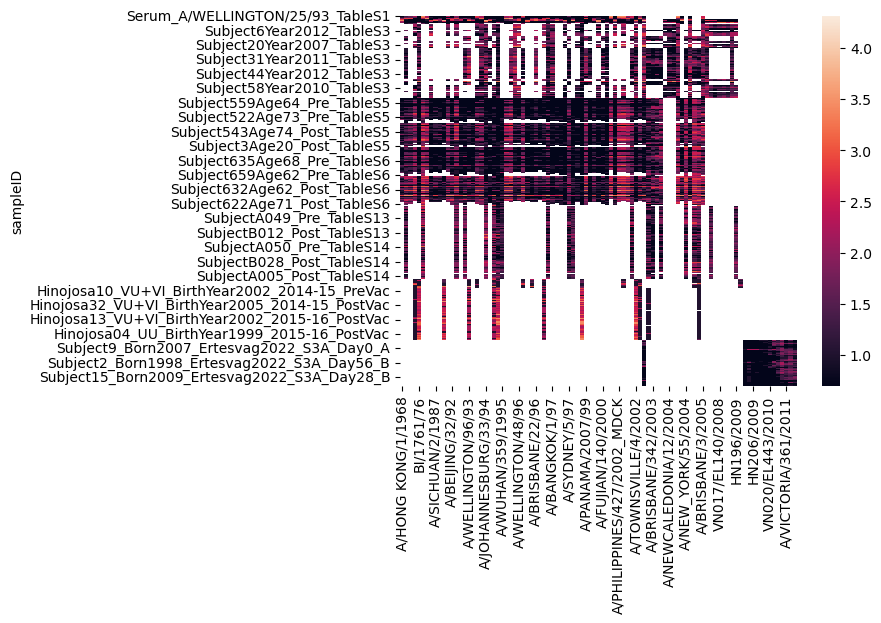

In [2]:
# Load in antisera-virus data as pd.DataFrames
all_HI_df = pd.read_csv("data/all_data.csv", index_col='sampleID')
all_antisera_df = pd.read_csv("data/all_data_antisera_table.csv", index_col='sampleID')
all_HI_data_tables  = HI_data_tables() # Create HI_data_tables object
all_HI_data_tables.add_HI_data(HI_df=all_HI_df,
                               antisera_df=all_antisera_df) # Add data from Tal's ad Rong's original paper
all_HI_data_tables.compute_virus_dates()
sns.heatmap(all_HI_data_tables.HI_data)

# Grid Search Analysis on Matrix Completion Model
Find which hypereparameters can be tuned to improve the performance of matrix completion between two datasets with low transferability

## General Schema of Grid Search


In [5]:
np.random.seed(10) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS1', 'TableS5', 'TableS6', 'TableS13', 'TableS14', 'fon_children', 'fon_ferrets', 'hin_vu14vi15', 'hin_vu15vi16', 'hin_u15u16',  ] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [5, 10, 15, 20, 25] # Number of overlapping viruses to train on 
train_trees_options = [10, 50, 100, 500, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results.csv")

ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_10_best_trees_1, RMSE: 0.8521655217106443
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_10_best_trees_3, RMSE: 0.8237802950972875
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_10_best_trees_5, RMSE: 0.8038993634755062
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_10_best_trees_8, RMSE: 0.7990571476048189
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_10_best_trees_10, RMSE: 0.8031289756050862

ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_50_best_trees_1, RMSE: 0.9546953946346208
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_50_best_trees_3, RMSE: 0.9399125931366534
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_50_best_trees_5, RMSE: 0.9261294

ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_8, RMSE: 0.6771598323923425
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_10, RMSE: 0.6796106750956087
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_20, RMSE: 0.681964470096718
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_50, RMSE: 0.6784589869651404
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_100, RMSE: 0.6782792764414668
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_200, RMSE: 0.680207070420198
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_300, RMSE: 0.679685845454446
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_tree

ensemble no. 16, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_10_best_trees_5, RMSE: 0.5498913189056656
ensemble no. 16, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_10_best_trees_8, RMSE: 0.5423190393515362
ensemble no. 16, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_10_best_trees_10, RMSE: 0.5419057620439396

ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_50_best_trees_1, RMSE: 0.5521732043900103
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_50_best_trees_3, RMSE: 0.5414416579982066
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_50_best_trees_5, RMSE: 0.5435549574143176
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_50_best_trees_8, RMSE: 0.5376436945899445
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_50_best_trees_10

ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_8, RMSE: 0.5835122401239825
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_10, RMSE: 0.5854656251747815
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_20, RMSE: 0.583803805017808
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_50, RMSE: 0.5827152781485904
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_100, RMSE: 0.5871682786240044
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_200, RMSE: 0.5889120494316352
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_300, RMSE: 0.5911104059155349
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500

ensemble no. 31, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_10_best_trees_5, RMSE: 0.33149535865600993
ensemble no. 31, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_10_best_trees_8, RMSE: 0.32206806627855744
ensemble no. 31, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_10_best_trees_10, RMSE: 0.3178812155663312

ensemble no. 32, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_50_best_trees_1, RMSE: 0.426969795275661
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_50_best_trees_3, RMSE: 0.39169758252624076
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_50_best_trees_5, RMSE: 0.37743731499682054
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_50_best_trees_8, RMSE: 0.366585832730113
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_50_best_trees_

ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_5, RMSE: 0.29525833925821526
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_8, RMSE: 0.2934023525013384
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_10, RMSE: 0.2918958874752039
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_20, RMSE: 0.27727308969935605
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_50, RMSE: 0.27367265203123076
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_100, RMSE: 0.2664571110347584
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_200, RMSE: 0.2668150237947257
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_5

ensemble no. 45, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.30641605410386435

ensemble no. 46, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_10_best_trees_1, RMSE: 0.24531267973681609
ensemble no. 46, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_10_best_trees_3, RMSE: 0.23136150793881569
ensemble no. 46, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_10_best_trees_5, RMSE: 0.226321733714362
ensemble no. 46, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_10_best_trees_8, RMSE: 0.22918447152577548
ensemble no. 46, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_10_best_trees_10, RMSE: 0.22632379876303005

ensemble no. 47, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_50_best_trees_1, RMSE: 0.2246414679354513
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_50_best

ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_1, RMSE: 0.4544562027672008
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_3, RMSE: 0.4323624215526932
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_5, RMSE: 0.42878185448708445
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_8, RMSE: 0.4224918717567174
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_10, RMSE: 0.41569645864669924
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_20, RMSE: 0.416497372551374
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_50, RMSE: 0.41370886592648365
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees

ensemble no. 60, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_1000_best_trees_500, RMSE: 0.2537440569365279
ensemble no. 60, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_1000_best_trees_750, RMSE: 0.25307972209112917

ensemble no. 61, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_1, RMSE: 0.2714380943099593
ensemble no. 61, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_3, RMSE: 0.24401458456851446
ensemble no. 61, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_5, RMSE: 0.2386089799447832
ensemble no. 61, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_8, RMSE: 0.22761745220038387
ensemble no. 61, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_10, RMSE: 0.2291010279302748

ensemble no. 62, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_50_b

ensemble no. 68, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_100_best_trees_50, RMSE: 0.23034306203397886
ensemble no. 68, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_100_best_trees_100, RMSE: 0.2324960001908438

ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_1, RMSE: 0.3106152014053718
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_3, RMSE: 0.28416154222366713
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_5, RMSE: 0.26434457930622457
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_8, RMSE: 0.25450209110111555
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_10, RMSE: 0.25039094672731005
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_5

ensemble no. 75, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_1000_best_trees_100, RMSE: 0.21640794196354118
ensemble no. 75, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_1000_best_trees_200, RMSE: 0.21818410089126755
ensemble no. 75, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_1000_best_trees_300, RMSE: 0.21858550931521753
ensemble no. 75, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_1000_best_trees_500, RMSE: 0.2191716997123792
ensemble no. 75, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_1000_best_trees_750, RMSE: 0.22136032493544971

ensemble no. 76, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_10_best_trees_1, RMSE: 0.24162716829608633
ensemble no. 76, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_10_best_trees_3, RMSE: 0.22443063051600515
ensemble no. 76, full_comparison_name: TableS3.2_to_TableS13_n_features_5_tra

ensemble no. 83, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_100_best_trees_10, RMSE: 0.14600416030687058
ensemble no. 83, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_100_best_trees_20, RMSE: 0.1456762369296324
ensemble no. 83, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_100_best_trees_50, RMSE: 0.14917327280371676
ensemble no. 83, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_100_best_trees_100, RMSE: 0.1536452724615016

ensemble no. 84, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_500_best_trees_1, RMSE: 0.07740882328993913
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_500_best_trees_3, RMSE: 0.07228597065270767
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_500_best_trees_5, RMSE: 0.0692903190231575
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train

ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_20, RMSE: 0.06520287399346632
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_50, RMSE: 0.06676967899141786
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_100, RMSE: 0.06748171743410798
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_200, RMSE: 0.07053742260299384
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_300, RMSE: 0.0730108748836381
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_500, RMSE: 0.07812158688574891
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_750, RMSE: 0.082131789305988

ensemble no. 91, full_comparison_name: TableS3.2_to_TableS13_n_fea

ensemble no. 98, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_100_best_trees_10, RMSE: 0.0570030894613436
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_100_best_trees_20, RMSE: 0.06339435328363564
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_100_best_trees_50, RMSE: 0.0768646773881348
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_100_best_trees_100, RMSE: 0.08912483881037056

ensemble no. 99, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_500_best_trees_1, RMSE: 0.18400875239578535
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_500_best_trees_3, RMSE: 0.1796216923521103
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_500_best_trees_5, RMSE: 0.16492006954325814
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train

ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_20, RMSE: 0.3833238363997873
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_50, RMSE: 0.38299644156735907
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_100, RMSE: 0.3844252308484061
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_200, RMSE: 0.38548824753848127
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_300, RMSE: 0.3866091468468569
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_500, RMSE: 0.38738316316932303
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_750, RMSE: 0.38762085953526165

ensemble no. 106, full_comparison_name: TableS3.2_to_TableS14_n_fe

ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_1, RMSE: 0.06674395842887182
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_3, RMSE: 0.06292296452550049
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_5, RMSE: 0.06453050407965877
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_8, RMSE: 0.0627513910442359
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_10, RMSE: 0.06148611225055603
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_20, RMSE: 0.06384237711441816
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_50, RMSE: 0.06814699026196067
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_1

ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_1, RMSE: 0.16814836059868313
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_3, RMSE: 0.1483197826738585
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_5, RMSE: 0.14041633544667997
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_8, RMSE: 0.1354350646884003
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_10, RMSE: 0.13636691264804987
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_20, RMSE: 0.137019013201734
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_50, RMSE: 0.1356996036805222
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_feature

ensemble no. 127, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_50_best_trees_20, RMSE: 0.3629976468751357
ensemble no. 127, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_50_best_trees_50, RMSE: 0.3591231192056957

ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_1, RMSE: 0.5025564744748149
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_3, RMSE: 0.43549623904283064
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_5, RMSE: 0.44869699365839394
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_8, RMSE: 0.44623159582209815
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_10, RMSE: 0.4443799322311397
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_

ensemble no. 134, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_500_best_trees_200, RMSE: 0.35652352095887835
ensemble no. 134, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_500_best_trees_300, RMSE: 0.3544219802293417
ensemble no. 134, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_500_best_trees_500, RMSE: 0.3532732080180788

ensemble no. 135, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.3703683132955784
ensemble no. 135, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.3951602598809022
ensemble no. 135, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.3765979076194096
ensemble no. 135, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.36199146026083195
ensemble no. 135, full_comparison_name: Ta

ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_1, RMSE: 0.18177738640473834
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_3, RMSE: 0.186070605175717
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_5, RMSE: 0.18875124146210212
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_8, RMSE: 0.1836471531457716
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_10, RMSE: 0.18103653979796644
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_20, RMSE: 0.18302471331860432
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_50, RMSE: 0.1920411353914253

ensemble no. 143, full_comparison_name: TableS3.2_to_fo

ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_20, RMSE: 0.21675087852098765
ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_50, RMSE: 0.223341140771254
ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_100, RMSE: 0.23072517162158193
ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_200, RMSE: 0.23179817841075248
ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_300, RMSE: 0.2356074882008136
ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_500, RMSE: 0.2407284717333536

ensemble no. 150, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_1000_best_trees_1, RMSE: 0.2958798523582917
ensemble no. 150, full_comparison_name: T

ensemble no. 156, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_10_best_trees_1, RMSE: 0.4503884020628222
ensemble no. 156, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_10_best_trees_3, RMSE: 0.44478990996458123
ensemble no. 156, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_10_best_trees_5, RMSE: 0.4495416730893619
ensemble no. 156, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_10_best_trees_8, RMSE: 0.45423715764525224
ensemble no. 156, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_10_best_trees_10, RMSE: 0.459133222321022

ensemble no. 157, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_50_best_trees_1, RMSE: 0.6235457720241387
ensemble no. 157, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_50_best_trees_3, RMSE: 0.6066782839860875
ensemble no. 157, full_comparison_name: TableS3.2_to_fon_ferrets_n

ensemble no. 163, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_100_best_trees_50, RMSE: 0.459059105270021
ensemble no. 163, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_100_best_trees_100, RMSE: 0.4670899905994393

ensemble no. 164, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_500_best_trees_1, RMSE: 0.37630652740226755
ensemble no. 164, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_500_best_trees_3, RMSE: 0.4136595823645212
ensemble no. 164, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_500_best_trees_5, RMSE: 0.40277198562093225
ensemble no. 164, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_500_best_trees_8, RMSE: 0.3926653704979717
ensemble no. 164, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_500_best_trees_10, RMSE: 0.38805416149432337
ensemble no. 164, full_comparison_name: TableS3.2_to_fo

ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_20, RMSE: 0.4053495103125019
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_50, RMSE: 0.40651416235052573
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_100, RMSE: 0.40559707860268873
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_200, RMSE: 0.40765147067564406
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_300, RMSE: 0.4104008622017229
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_500, RMSE: 0.4146997591632334
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.41978444377291657

ensemble no. 171, full_comparison_name

ensemble no. 177, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_50_best_trees_50, RMSE: 0.3947260337736002

ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_1, RMSE: 0.4431321972343244
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_3, RMSE: 0.4221801840169148
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_5, RMSE: 0.42102343157446165
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_8, RMSE: 0.4253668645347816
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_10, RMSE: 0.4379869010948773
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_20, RMSE: 0.4329300672575844
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_v

ensemble no. 184, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_500_best_trees_300, RMSE: 0.23479616652946272
ensemble no. 184, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_500_best_trees_500, RMSE: 0.25514391246092166

ensemble no. 185, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.3300772258458406
ensemble no. 185, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.2882995562345159
ensemble no. 185, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.23487985443138523
ensemble no. 185, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.22474079863400032
ensemble no. 185, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_10, RMSE: 0.2100917778627561
ensemble no. 185, full_comparison_name: 

ensemble no. 191, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_10_best_trees_10, RMSE: 0.2418247081602446

ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_1, RMSE: 0.15758971835199015
ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_3, RMSE: 0.1478149098505147
ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_5, RMSE: 0.14817767452955144
ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_8, RMSE: 0.14506071340678545
ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_10, RMSE: 0.14493140861517015
ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_20, RMSE: 0.15320868764536155
ensemble no. 192, full_comparison_name: TableS3.2_to_

ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_20, RMSE: 0.17229397592870083
ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_50, RMSE: 0.1719946310060246
ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_100, RMSE: 0.18237782549564524
ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_200, RMSE: 0.1985120689513875
ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_300, RMSE: 0.21394165208300692
ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_500, RMSE: 0.23705010541250876

ensemble no. 200, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_1000_best_trees_1, RMSE: 0.22144307591303494
ensemble no. 200, full_comparison_name

ensemble no. 206, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_1, RMSE: 0.25464114333047827
ensemble no. 206, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_3, RMSE: 0.2826377532572026
ensemble no. 206, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_5, RMSE: 0.30201130592128084
ensemble no. 206, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_8, RMSE: 0.32593858908437356
ensemble no. 206, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_10, RMSE: 0.3359898858331427

ensemble no. 207, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_50_best_trees_1, RMSE: 0.17473333243537217
ensemble no. 207, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_50_best_trees_3, RMSE: 0.1472436433028388
ensemble no. 207, full_comparison_name: TableS3.2_to_hin

ensemble no. 213, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_100_best_trees_50, RMSE: 0.3078553283118365
ensemble no. 213, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_100_best_trees_100, RMSE: 0.3302592675691254

ensemble no. 214, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_500_best_trees_1, RMSE: 0.24187122137238298
ensemble no. 214, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_500_best_trees_3, RMSE: 0.22892087855158677
ensemble no. 214, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_500_best_trees_5, RMSE: 0.21985145734195505
ensemble no. 214, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_500_best_trees_8, RMSE: 0.22505734861371113
ensemble no. 214, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_500_best_trees_10, RMSE: 0.22414647417249814
ensemble no. 214, full_comparison_name: Table

ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_50, RMSE: 0.2509214897935897
ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_100, RMSE: 0.2538944911942195
ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_200, RMSE: 0.2631701043089439
ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_300, RMSE: 0.2696076628773572
ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_500, RMSE: 0.2785918398830395
ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.2895451155299817

ensemble no. 221, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_25_train_trees_10_best_trees_1, RMSE: 0.2813048279319529
ensemble no. 221, full_comparison_name

ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_1, RMSE: 0.7355397967984378
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_3, RMSE: 0.6698137587727836
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_5, RMSE: 0.649692168924988
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_8, RMSE: 0.6216862770819473
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_10, RMSE: 0.6143656178209584
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_20, RMSE: 0.6213395351410171
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_50, RMSE: 0.6241608414855918
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features

ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.3375192944610018
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.29431554131456233
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.2897489873212907
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.28969996436279166
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_10, RMSE: 0.2857226728584223
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_20, RMSE: 0.2800736476518353
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_50, RMSE: 0.2821229304196014
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_

ensemble no. 242, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_50_best_trees_20, RMSE: 0.23092270344470017
ensemble no. 242, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_50_best_trees_50, RMSE: 0.26094162511783464

ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_100_best_trees_1, RMSE: 0.3610048570073658
ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_100_best_trees_3, RMSE: 0.36873795692634537
ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_100_best_trees_5, RMSE: 0.37071111690023445
ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_100_best_trees_8, RMSE: 0.36416817162029586
ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_100_best_trees_10, RMSE: 0.37515898966418076
ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u

ensemble no. 249, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_500_best_trees_200, RMSE: 0.23813803312781556
ensemble no. 249, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_500_best_trees_300, RMSE: 0.2503920662189342
ensemble no. 249, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_500_best_trees_500, RMSE: 0.27271301242192514

ensemble no. 250, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_1000_best_trees_1, RMSE: 0.22068791214167557
ensemble no. 250, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_1000_best_trees_3, RMSE: 0.1975398777110131
ensemble no. 250, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_1000_best_trees_5, RMSE: 0.20300808312050322
ensemble no. 250, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_1000_best_trees_8, RMSE: 0.1996435850187488
ensemble no. 250, full_comparison_name: TableS3.2_to_h

ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_1, RMSE: 0.6955716127271346
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_3, RMSE: 0.6751918332237756
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_5, RMSE: 0.6612128487704104
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_8, RMSE: 0.6550666359202914
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_10, RMSE: 0.6484544557779397
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_20, RMSE: 0.6440211995389539
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_50, RMSE: 0.635660647143464

ensemble no. 258, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_100_bes

ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_20, RMSE: 0.5534024414136383
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_50, RMSE: 0.5516840887852752
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_100, RMSE: 0.5552391783733439
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_200, RMSE: 0.5553957419680777
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_300, RMSE: 0.5550581937699192
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_500, RMSE: 0.5582492476592965

ensemble no. 265, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_1000_best_trees_1, RMSE: 0.6637186469791707
ensemble no. 265, full_comparison_name: TableS3.1_to_TableS1_n_features_15_tra

ensemble no. 271, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_10_best_trees_8, RMSE: 0.4738785320898641
ensemble no. 271, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_10_best_trees_10, RMSE: 0.47622994108626304

ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_best_trees_1, RMSE: 0.513502843497208
ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_best_trees_3, RMSE: 0.49969952799082773
ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_best_trees_5, RMSE: 0.4913378813999448
ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_best_trees_8, RMSE: 0.4909116369589037
ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_best_trees_10, RMSE: 0.4947338501610936
ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_bes

ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_8, RMSE: 0.4769641694863573
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_10, RMSE: 0.47651776145855895
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_20, RMSE: 0.47600545175754005
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_50, RMSE: 0.4751613518832795
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_100, RMSE: 0.47303015234278933
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_200, RMSE: 0.47258568205145807
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_300, RMSE: 0.4735562452798525
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_tree

ensemble no. 286, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_10_best_trees_1, RMSE: 0.4786462233243118
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_10_best_trees_3, RMSE: 0.4109438846423521
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_10_best_trees_5, RMSE: 0.4077727664618752
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_10_best_trees_8, RMSE: 0.40274431720905896
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_10_best_trees_10, RMSE: 0.40728364945103523

ensemble no. 287, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_50_best_trees_1, RMSE: 0.37164924103156083
ensemble no. 287, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_50_best_trees_3, RMSE: 0.36384260077950614
ensemble no. 287, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_50_b

ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_1, RMSE: 0.3911957893492672
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_3, RMSE: 0.36641987930147046
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_5, RMSE: 0.356665193245395
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_8, RMSE: 0.35073455181705465
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_10, RMSE: 0.3491980913127382
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_20, RMSE: 0.35094793210446273
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_50, RMSE: 0.3479149588791482
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_tree

ensemble no. 300, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_300, RMSE: 0.32170524629111047
ensemble no. 300, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_500, RMSE: 0.32528594403540817
ensemble no. 300, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_750, RMSE: 0.3285623913709571

ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_10_best_trees_1, RMSE: 0.5684078969616316
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_10_best_trees_3, RMSE: 0.516797077977909
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_10_best_trees_5, RMSE: 0.5171375909563457
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_10_best_trees_8, RMSE: 0.5107931369151736
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_1

ensemble no. 308, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_100_best_trees_50, RMSE: 0.4046502976409966
ensemble no. 308, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_100_best_trees_100, RMSE: 0.4028667509779233

ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_500_best_trees_1, RMSE: 0.4810159174083438
ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_500_best_trees_3, RMSE: 0.4204803067180782
ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_500_best_trees_5, RMSE: 0.41462584739067515
ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_500_best_trees_8, RMSE: 0.4088920414408983
ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_500_best_trees_10, RMSE: 0.4047297519502575
ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_tre

ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_100, RMSE: 0.37303512491444313
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_200, RMSE: 0.3738502011459018
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_300, RMSE: 0.37398573667274176
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_500, RMSE: 0.37309375003228384
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_750, RMSE: 0.37278116048458354

ensemble no. 316, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_10_best_trees_1, RMSE: 0.38010903796463674
ensemble no. 316, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_10_best_trees_3, RMSE: 0.37042247306140536
ensemble no. 316, full_comparison_name: TableS3.1_to_TableS6_n_feature

ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_100_best_trees_8, RMSE: 0.35466856912740063
ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_100_best_trees_10, RMSE: 0.34918584453058676
ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_100_best_trees_20, RMSE: 0.35432544416137585
ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_100_best_trees_50, RMSE: 0.35116305250527047
ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_100_best_trees_100, RMSE: 0.3527523522617202

ensemble no. 324, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_1, RMSE: 0.43043596191466893
ensemble no. 324, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_3, RMSE: 0.3885568600576277
ensemble no. 324, full_comparison_name: TableS3.1_to_TableS6_n_features_25_trai

ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_10, RMSE: 0.42023467981727264
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_20, RMSE: 0.4153624971448258
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_50, RMSE: 0.4138486573465015
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_100, RMSE: 0.41033275326021146
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_200, RMSE: 0.40870042486409236
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_300, RMSE: 0.40795648022524034
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_500, RMSE: 0.4065282110807456
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_feat

ensemble no. 337, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_50_best_trees_50, RMSE: 0.20130114957227777

ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_1, RMSE: 0.21241046817906364
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_3, RMSE: 0.19764273061240936
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_5, RMSE: 0.18801196374690107
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_8, RMSE: 0.18779337696684895
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_10, RMSE: 0.1847008616875485
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_20, RMSE: 0.1810561636835074
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15

ensemble no. 344, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_500_best_trees_500, RMSE: 0.22123084087107095

ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_1, RMSE: 0.32086069567790915
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_3, RMSE: 0.26360787164179256
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_5, RMSE: 0.2581251885918964
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_8, RMSE: 0.2583353049546838
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_10, RMSE: 0.25760919026619117
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_20, RMSE: 0.2551276459178244
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_feat

ensemble no. 352, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_50_best_trees_8, RMSE: 0.46826515711346944
ensemble no. 352, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_50_best_trees_10, RMSE: 0.4679369099946518
ensemble no. 352, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_50_best_trees_20, RMSE: 0.4649236489850905
ensemble no. 352, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_50_best_trees_50, RMSE: 0.4645736655696653

ensemble no. 353, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_1, RMSE: 0.4398690549812229
ensemble no. 353, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_3, RMSE: 0.4115692273231733
ensemble no. 353, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_5, RMSE: 0.40814656870659693
ensemble no. 353, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_1

ensemble no. 359, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_500_best_trees_200, RMSE: 0.3079459199744763
ensemble no. 359, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_500_best_trees_300, RMSE: 0.3084845426785823
ensemble no. 359, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_500_best_trees_500, RMSE: 0.3103152290465906

ensemble no. 360, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.37693750014957467
ensemble no. 360, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.3442469050357457
ensemble no. 360, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.33322339765881476
ensemble no. 360, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.32848621412998097
ensemble no. 360, full_comparison_name: TableS3.1_to_TableS14_n_featu

ensemble no. 366, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_10_best_trees_10, RMSE: 0.1822602146177652

ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_1, RMSE: 0.3365958968769384
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_3, RMSE: 0.2760447000746958
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_5, RMSE: 0.27229957418386264
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_8, RMSE: 0.26186412652438107
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_10, RMSE: 0.25593014325316227
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_20, RMSE: 0.24855528654714637
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_

ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_8, RMSE: 0.2226853211529253
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_10, RMSE: 0.2196772081118894
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_20, RMSE: 0.21352259581899452
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_50, RMSE: 0.21006398424188968
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_100, RMSE: 0.20793198983732128
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_200, RMSE: 0.21014701187752152
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_300, RMSE: 0.21200893916851385
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_featu

ensemble no. 380, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_1000_best_trees_500, RMSE: 0.3558846411522776
ensemble no. 380, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_1000_best_trees_750, RMSE: 0.3562014391308334

ensemble no. 381, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_10_best_trees_1, RMSE: 0.2095738466285682
ensemble no. 381, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_10_best_trees_3, RMSE: 0.1967370092623493
ensemble no. 381, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_10_best_trees_5, RMSE: 0.18636654064434838
ensemble no. 381, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_10_best_trees_8, RMSE: 0.19505996546718204
ensemble no. 381, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_10_best_trees_10, RMSE: 0.2005901480218054

ensemble no. 382, full_comparison_name: TableS3.1_t

ensemble no. 388, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_100_best_trees_20, RMSE: 0.19695405567946225
ensemble no. 388, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_100_best_trees_50, RMSE: 0.19811513434803707
ensemble no. 388, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_100_best_trees_100, RMSE: 0.20437412120203605

ensemble no. 389, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_500_best_trees_1, RMSE: 0.13607607442940298
ensemble no. 389, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_500_best_trees_3, RMSE: 0.12028353963034275
ensemble no. 389, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_500_best_trees_5, RMSE: 0.11890414597842093
ensemble no. 389, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_500_best_trees_8, RMSE: 0.1185748117753757
ensemble no. 389, full_comparison_name: Tabl

ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_20, RMSE: 0.16070991815084554
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_50, RMSE: 0.1531752121832549
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_100, RMSE: 0.14968389085100395
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_200, RMSE: 0.15352845651331407
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_300, RMSE: 0.15242966422812168
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_500, RMSE: 0.1531328254017242
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.15168023441826187

ensemble no. 396, full_compari

ensemble no. 402, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_50_best_trees_50, RMSE: 0.5192357220266349

ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_1, RMSE: 0.7568189630363792
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_3, RMSE: 0.7130715043480498
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_5, RMSE: 0.7204428838345884
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_8, RMSE: 0.7126885022476772
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_10, RMSE: 0.7129364945219729
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_20, RMSE: 0.7050699385680748
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n

ensemble no. 409, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_300, RMSE: 0.4538429544086882
ensemble no. 409, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_500, RMSE: 0.4557777810989799

ensemble no. 410, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.5109192429164003
ensemble no. 410, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.45609276177753366
ensemble no. 410, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.4616398903990572
ensemble no. 410, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.4596173257707563
ensemble no. 410, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_10, RMSE: 0.46820344809049824
ensemble no. 410, full_comparison_name: TableS3.1

ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_1, RMSE: 0.3022055283772088
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_3, RMSE: 0.30344147517851194
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_5, RMSE: 0.3031618107037106
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_8, RMSE: 0.3040668682728249
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_10, RMSE: 0.30519855073041613
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_20, RMSE: 0.3132410274680826
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_50, RMSE: 0.33067868190627125

ensemble no. 418, full_comparison_name: TableS3.1_to_fon_ferre

ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_20, RMSE: 0.3380054747329875
ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_50, RMSE: 0.33722803761384507
ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_100, RMSE: 0.33849953346685957
ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_200, RMSE: 0.3458756333516828
ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_300, RMSE: 0.35150548427488276
ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_500, RMSE: 0.3600668875391916

ensemble no. 425, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_1000_best_trees_1, RMSE: 0.27882365662829867
ensemble no. 425, full_comparison_name: TableS

ensemble no. 431, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_10_best_trees_1, RMSE: 0.34141098677944276
ensemble no. 431, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_10_best_trees_3, RMSE: 0.29010008718172636
ensemble no. 431, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_10_best_trees_5, RMSE: 0.29144660564653824
ensemble no. 431, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_10_best_trees_8, RMSE: 0.31188151610614734
ensemble no. 431, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_10_best_trees_10, RMSE: 0.31892864199769166

ensemble no. 432, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_50_best_trees_1, RMSE: 0.4687312919243263
ensemble no. 432, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_50_best_trees_3, RMSE: 0.5208465941086236
ensemble no. 432, full_comparison_name: TableS3.1_to_hi

ensemble no. 438, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_100_best_trees_50, RMSE: 0.3069013488611288
ensemble no. 438, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_100_best_trees_100, RMSE: 0.3350648872927628

ensemble no. 439, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_500_best_trees_1, RMSE: 0.3435291248562872
ensemble no. 439, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_500_best_trees_3, RMSE: 0.37272454508051733
ensemble no. 439, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_500_best_trees_5, RMSE: 0.34347073645740533
ensemble no. 439, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_500_best_trees_8, RMSE: 0.3441190392921321
ensemble no. 439, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_500_best_trees_10, RMSE: 0.3548428124432737
ensemble no. 439, full_comparison_name: TableS3.

ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_50, RMSE: 0.22751383154611227
ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_100, RMSE: 0.23495809390501057
ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_200, RMSE: 0.23608123670215922
ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_300, RMSE: 0.2389600461025958
ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_500, RMSE: 0.2456758324198217
ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.26055752355247186

ensemble no. 446, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_25_train_trees_10_best_trees_1, RMSE: 0.2811156126240728
ensemble no. 446, full_comparison_

ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_1, RMSE: 0.39581045399889575
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_3, RMSE: 0.3855489567743916
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_5, RMSE: 0.3893822346860691
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_8, RMSE: 0.3748041673015294
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_10, RMSE: 0.36768802283594576
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_20, RMSE: 0.37266343756152787
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_50, RMSE: 0.3948983853118376
ensemble no. 453, full_comparison_name: TableS3.1_to_hin

ensemble no. 459, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_500, RMSE: 0.36606328470001914

ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.5044618288050481
ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.38180223817960984
ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.40504841193010355
ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.3866955626507909
ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_10, RMSE: 0.4273902470111155
ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_20, RMSE: 0.4299602110754534
ensemble no. 460, full_comparison_name: T

ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_1, RMSE: 0.33758318048797276
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_3, RMSE: 0.34256048248543375
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_5, RMSE: 0.3455915521176478
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_8, RMSE: 0.3517427437668735
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_10, RMSE: 0.35368405957763094
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_20, RMSE: 0.35991751312458437
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_50, RMSE: 0.3882809478174722

ensemble no. 468, full_comparison_name: TableS3.1_to_h

ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_20, RMSE: 0.3394652991643372
ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_50, RMSE: 0.35244815195381907
ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_100, RMSE: 0.36229202743594197
ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_200, RMSE: 0.3752824679717323
ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_300, RMSE: 0.38285411119310353
ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_500, RMSE: 0.3954624043567869

ensemble no. 475, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_1000_best_trees_1, RMSE: 0.265751649254075
ensemble no. 475, full_comparison_name: T

ensemble no. 481, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_10_best_trees_10, RMSE: 0.48003110959332485

ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_1, RMSE: 0.5989613347134699
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_3, RMSE: 0.5376439353625745
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_5, RMSE: 0.5262239658989797
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_8, RMSE: 0.5172153708892288
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_10, RMSE: 0.5156505477369043
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_20, RMSE: 0.5262273904497308
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_featu

ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_20, RMSE: 0.2371400087825003
ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_50, RMSE: 0.23657005275563686
ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_100, RMSE: 0.23867991642112835
ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_200, RMSE: 0.24343797430246342
ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_300, RMSE: 0.25087541804106317
ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_500, RMSE: 0.2638551935613163

ensemble no. 490, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_1000_best_trees_1, RMSE: 0.2676411687034714
ensemble no. 490, full_comparison_name: TableS3.1_to_

ensemble no. 496, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_10_best_trees_1, RMSE: 0.33669792638218476
ensemble no. 496, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_10_best_trees_3, RMSE: 0.3279265787152625
ensemble no. 496, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_10_best_trees_5, RMSE: 0.316508347989357
ensemble no. 496, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_10_best_trees_8, RMSE: 0.30849382520297325
ensemble no. 496, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_10_best_trees_10, RMSE: 0.3100067394001996

ensemble no. 497, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_50_best_trees_1, RMSE: 0.3527777596852657
ensemble no. 497, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_50_best_trees_3, RMSE: 0.33947961046100433
ensemble no. 497, full_comparison_name: TableS3.1_to_hin_u15u16_n_featur

In [ ]:
'''
Must only train trees on viruses in intersection
'''

## Secondary grid search on tables with less viable featuers

In [3]:
np.random.seed(10) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS13', 'TableS14', 'fon_children', 'fon_ferrets', 'hin_vu14vi15', 'hin_vu15vi16', 'hin_u15u16',  ] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [3, 5, 6, 7, 8, 10] # Number of overlapping viruses to train on 
train_trees_options = [10, 50, 100, 500, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info_secondary.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results_secondary.csv")

ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_1, RMSE: 0.3399691167573087
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_3, RMSE: 0.33446202542637926
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_5, RMSE: 0.334715874860159
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_8, RMSE: 0.3345090116559127
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_10, RMSE: 0.3357574145478757

ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_50_best_trees_1, RMSE: 0.378909423781192
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_50_best_trees_3, RMSE: 0.3843958156427577
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_50_best_trees_5, RMSE: 0.

ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_10, RMSE: 0.28469849616507303
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_20, RMSE: 0.2821996724599135
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_50, RMSE: 0.27967487296188914
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_100, RMSE: 0.2792394923677183
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_200, RMSE: 0.27866670282437117
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_300, RMSE: 0.2789599205052203
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_500, RMSE: 0.2818791808085153

ensemble no. 10, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_100

ensemble no. 16, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_10_best_trees_10, RMSE: 0.21007157654220923

ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_1, RMSE: 0.32140136321748647
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_3, RMSE: 0.30146618905027933
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_5, RMSE: 0.2946022901219666
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_8, RMSE: 0.28763383570217854
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_10, RMSE: 0.2839414466991924
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_20, RMSE: 0.277859717601714
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_tre

ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_10, RMSE: 0.07942293289372537
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_20, RMSE: 0.08013669626577562
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_50, RMSE: 0.08062492678971732
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_100, RMSE: 0.08248354906090069
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_200, RMSE: 0.08590221720084315
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_300, RMSE: 0.08838338535490148
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_500, RMSE: 0.09457942195936322

ensemble no. 25, full_comparison_name: TableS3.2_to_TableS13_n_features_8_trai

ensemble no. 31, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_10_best_trees_10, RMSE: 0.41993808759578627

ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_1, RMSE: 0.2448832578434759
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_3, RMSE: 0.23315022069418406
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_5, RMSE: 0.23276663199987233
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_8, RMSE: 0.23073684695902497
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_10, RMSE: 0.23201413064617837
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_20, RMSE: 0.23086459281166805
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_

ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_10, RMSE: 0.2590476257452541
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_20, RMSE: 0.2596079798915557
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_50, RMSE: 0.25662922746822464
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_100, RMSE: 0.2557150697437162
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_200, RMSE: 0.2569361882302445
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_300, RMSE: 0.25858092991638937
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_500, RMSE: 0.2606948210940638

ensemble no. 40, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_tre

ensemble no. 46, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_10_best_trees_10, RMSE: 0.24836861870556246

ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_1, RMSE: 0.3295892473108123
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_3, RMSE: 0.3256252980188083
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_5, RMSE: 0.3070926323873311
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_8, RMSE: 0.3094386937662745
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_10, RMSE: 0.30802745644510904
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_20, RMSE: 0.30093850021955354
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_tre

ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_10, RMSE: 0.13616558517346755
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_20, RMSE: 0.13911174770917756
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_50, RMSE: 0.13644616629294698
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_100, RMSE: 0.13741384464659778
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_200, RMSE: 0.1375259842192981
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_300, RMSE: 0.13932594323003808
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_500, RMSE: 0.14311169205315352

ensemble no. 55, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train

ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_1, RMSE: 0.5854977683533407
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_3, RMSE: 0.6044776802435297
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_5, RMSE: 0.6046951092723111
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_8, RMSE: 0.6213220510876936
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_10, RMSE: 0.6151500664914229
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_20, RMSE: 0.6175352368374566
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_50, RMSE: 0.6003344722995636

ensemble no. 63, full_comparison_name: TableS3.2_to_fon_children_n_featu

ensemble no. 69, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_500_best_trees_50, RMSE: 0.3888749762700233
ensemble no. 69, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_500_best_trees_100, RMSE: 0.388570734292669
ensemble no. 69, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_500_best_trees_200, RMSE: 0.39385563543895086
ensemble no. 69, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_500_best_trees_300, RMSE: 0.39616381332025036
ensemble no. 69, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_500_best_trees_500, RMSE: 0.39818811557385797

ensemble no. 70, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_1000_best_trees_1, RMSE: 0.4794452709194844
ensemble no. 70, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_1000_best_trees_3, RMSE: 0.46703944790746554
ensemble no. 70, full_comparison_name: TableS3.2_to_fo

ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_1, RMSE: 0.3596531327824585
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_3, RMSE: 0.387718254817956
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_5, RMSE: 0.3790090955608945
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_8, RMSE: 0.37542664641947254
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_10, RMSE: 0.36356374858935336
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_20, RMSE: 0.3569190538416413
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_50, RMSE: 0.34770664637129395

ensemble no. 78, full_comparison_name: TableS3.2_to_fon_children_n_fea

ensemble no. 84, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_500_best_trees_50, RMSE: 0.33318365866034744
ensemble no. 84, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_500_best_trees_100, RMSE: 0.33460901419234906
ensemble no. 84, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_500_best_trees_200, RMSE: 0.3361695609651105
ensemble no. 84, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_500_best_trees_300, RMSE: 0.336747066224688
ensemble no. 84, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_500_best_trees_500, RMSE: 0.33692839945307607

ensemble no. 85, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_1000_best_trees_1, RMSE: 0.4884390831269128
ensemble no. 85, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_1000_best_trees_3, RMSE: 0.444807425714986
ensemble no. 85, full_comparison_name: TableS3.2_to_fon_

ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_1, RMSE: 0.7339917686840688
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_3, RMSE: 0.72399038932763
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_5, RMSE: 0.7252174529987578
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_8, RMSE: 0.7295607579481586
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_10, RMSE: 0.7259699337419179
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_20, RMSE: 0.7316926415099276
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_50, RMSE: 0.7373664077963222

ensemble no. 93, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_trai

ensemble no. 99, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_500_best_trees_50, RMSE: 0.5826900803320626
ensemble no. 99, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_500_best_trees_100, RMSE: 0.5848134941726989
ensemble no. 99, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_500_best_trees_200, RMSE: 0.5827222615320524
ensemble no. 99, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_500_best_trees_300, RMSE: 0.5824045171506944
ensemble no. 99, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_500_best_trees_500, RMSE: 0.58221723140958

ensemble no. 100, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_1000_best_trees_1, RMSE: 0.817864148338575
ensemble no. 100, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_1000_best_trees_3, RMSE: 0.8340402261289295
ensemble no. 100, full_comparison_name: TableS3.2_to_fon_ferrets_

ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_1, RMSE: 0.6068229289912342
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_3, RMSE: 0.6006159424935124
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_5, RMSE: 0.5900248582475949
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_8, RMSE: 0.5937892285120492
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_10, RMSE: 0.5861583765271324
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_20, RMSE: 0.5877291384494573
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_50, RMSE: 0.5886168673839615

ensemble no. 108, full_comparison_name: TableS3.2_to_fon_ferrets_n_featu

ensemble no. 114, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_500_best_trees_50, RMSE: 0.5745606617096689
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_500_best_trees_100, RMSE: 0.5729757737039967
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_500_best_trees_200, RMSE: 0.5765192954369461
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_500_best_trees_300, RMSE: 0.5747897094008225
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_500_best_trees_500, RMSE: 0.5771536556708522

ensemble no. 115, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_1000_best_trees_1, RMSE: 0.5631827968163234
ensemble no. 115, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_1000_best_trees_3, RMSE: 0.5099406089851636
ensemble no. 115, full_comparison_name: TableS3.2_to_fon_

ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_1, RMSE: 0.5227540921221469
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_3, RMSE: 0.5662330982689837
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_5, RMSE: 0.5510864279091159
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_8, RMSE: 0.5570811822770989
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_10, RMSE: 0.5487048165833164
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_20, RMSE: 0.5551180588100748
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_50, RMSE: 0.5499876197801585

ensemble no. 123, full_comparison_name: TableS3.2_to_hin_vu14vi15

ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_20, RMSE: 0.4145898717970016
ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_50, RMSE: 0.4075107063172458
ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_100, RMSE: 0.4116002747565417
ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_200, RMSE: 0.4153561526895253
ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_300, RMSE: 0.4192623054903159
ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_500, RMSE: 0.42861249034066223

ensemble no. 130, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_1000_best_trees_1, RMSE: 0.481197956368227
ensemble no. 130, full_comparison_name: TableS3.2_

ensemble no. 136, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_1, RMSE: 0.18089077881589777
ensemble no. 136, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_3, RMSE: 0.17126477002864757
ensemble no. 136, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_5, RMSE: 0.1740167637428895
ensemble no. 136, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_8, RMSE: 0.18982187140677748
ensemble no. 136, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_10, RMSE: 0.2009758424901864

ensemble no. 137, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_50_best_trees_1, RMSE: 0.23013831307095986
ensemble no. 137, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_50_best_trees_3, RMSE: 0.22025730347782677
ensemble no. 137, full_comparison_name: TableS3.2_to_hin_vu14v

ensemble no. 143, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_100_best_trees_100, RMSE: 0.2535608242482536

ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_1, RMSE: 0.28080451596171935
ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_3, RMSE: 0.26991628043748633
ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_5, RMSE: 0.26033186702233585
ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_8, RMSE: 0.25732736524428107
ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_10, RMSE: 0.25574702725898957
ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_20, RMSE: 0.2619731610622458
ensemble no. 144, full_comparison_name: TableS3.2_to

ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_50, RMSE: 0.28824114712202487
ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_100, RMSE: 0.2845887273315266
ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_200, RMSE: 0.28875610875505475
ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_300, RMSE: 0.29032051331982545
ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_500, RMSE: 0.29526618311948666
ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_750, RMSE: 0.30019302710691614

ensemble no. 151, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_3_train_trees_10_best_trees_1, RMSE: 0.7677192153389215
ensemble no. 151, full_comparison_

ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_1, RMSE: 0.3351714996607164
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_3, RMSE: 0.3455576434845295
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_5, RMSE: 0.3379178467155256
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_8, RMSE: 0.3318429921792172
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_10, RMSE: 0.3311106132778066
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_20, RMSE: 0.33028143316925923
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_50, RMSE: 0.33246673959896816
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_

ensemble no. 164, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_500_best_trees_500, RMSE: 0.4676756583080534

ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_1, RMSE: 0.6025258760753532
ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_3, RMSE: 0.5750135204594925
ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_5, RMSE: 0.5712373647687989
ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_8, RMSE: 0.5681883797863313
ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_10, RMSE: 0.564721022129971
ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_20, RMSE: 0.5621319801252485
ensemble no. 165, full_comparison_name: TableS3.2_to

ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_1, RMSE: 0.29986204939899197
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_3, RMSE: 0.28752338409844413
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_5, RMSE: 0.27810088103874936
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_8, RMSE: 0.29352628986604656
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_10, RMSE: 0.2949812875738823
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_20, RMSE: 0.2960221813060882
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_50, RMSE: 0.31095350442852704

ensemble no. 173, full_comparison_name: TableS3.2_to_hin_vu1

ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_20, RMSE: 0.5690896394506207
ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_50, RMSE: 0.553423007063196
ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_100, RMSE: 0.5548309202518641
ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_200, RMSE: 0.5638787191772616
ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_300, RMSE: 0.564418727062575
ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_500, RMSE: 0.5580749154862545

ensemble no. 180, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.4493560789600366
ensemble no. 180, full_comparison_name: Table

ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_1, RMSE: 0.4593695186578715
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_3, RMSE: 0.49664051351174177
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_5, RMSE: 0.49306925660797857
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_8, RMSE: 0.5026820868963299
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_10, RMSE: 0.5081757193416616
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_20, RMSE: 0.531309105616219
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_50, RMSE: 0.5466448144515692

ensemble no. 188, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_t

ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_20, RMSE: 0.7208102262140336
ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_50, RMSE: 0.7215628601611429
ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_100, RMSE: 0.7384262090661019
ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_200, RMSE: 0.7420299856790024
ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_300, RMSE: 0.7475295043941345
ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_500, RMSE: 0.7529425583386707

ensemble no. 195, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_1000_best_trees_1, RMSE: 0.48632046160193343
ensemble no. 195, full_comparison_name: TableS3.2_to_hin_u15u16

ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_1, RMSE: 0.22104238668223705
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_3, RMSE: 0.20644877476839354
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_5, RMSE: 0.20350763829783558
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_8, RMSE: 0.19420394911692648
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_10, RMSE: 0.19422854566289516
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_20, RMSE: 0.20584562481702406
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_50, RMSE: 0.24014927435141006

ensemble no. 203, full_comparison_name: TableS3.2_to_hin_u15u16_n_featur

ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_20, RMSE: 0.32834907138156094
ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_50, RMSE: 0.32528354291719963
ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_100, RMSE: 0.32353082942798284
ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_200, RMSE: 0.32701353158187624
ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_300, RMSE: 0.33045628132532995
ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_500, RMSE: 0.3425197197675255

ensemble no. 210, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.4922642694088435
ensemble no. 210, full_comparison_name: TableS3.2_to

ensemble no. 216, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_10_best_trees_8, RMSE: 0.4045461413129575
ensemble no. 216, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_10_best_trees_10, RMSE: 0.40021096001012635

ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_best_trees_1, RMSE: 0.39835681891658753
ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_best_trees_3, RMSE: 0.3676779792804893
ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_best_trees_5, RMSE: 0.3562612339212716
ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_best_trees_8, RMSE: 0.35914380124028783
ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_best_trees_10, RMSE: 0.3579719586889543
ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_b

ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_8, RMSE: 0.28027642428842653
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_10, RMSE: 0.27964679339595655
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_20, RMSE: 0.28060753880503375
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_50, RMSE: 0.27895644149737175
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_100, RMSE: 0.2774268064829211
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_200, RMSE: 0.27540910972905147
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_300, RMSE: 0.2749865774439749
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_t

ensemble no. 231, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_10_best_trees_1, RMSE: 0.27005702157056993
ensemble no. 231, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_10_best_trees_3, RMSE: 0.23862522607689013
ensemble no. 231, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_10_best_trees_5, RMSE: 0.2383178807717781
ensemble no. 231, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_10_best_trees_8, RMSE: 0.23394920982609846
ensemble no. 231, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_10_best_trees_10, RMSE: 0.23607295819462673

ensemble no. 232, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_50_best_trees_1, RMSE: 0.36026102192256587
ensemble no. 232, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_50_best_trees_3, RMSE: 0.3167099899305932
ensemble no. 232, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_50_

ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_1, RMSE: 0.2118914096950501
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_3, RMSE: 0.1985119327568443
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_5, RMSE: 0.19977492746858214
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_8, RMSE: 0.19243372451997257
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_10, RMSE: 0.1894296999034787
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_20, RMSE: 0.18570950681838305
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_50, RMSE: 0.18308719281048488
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_

ensemble no. 245, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.3763621225511319
ensemble no. 245, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.3756863070252816
ensemble no. 245, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.3753209148252313

ensemble no. 246, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_10_best_trees_1, RMSE: 0.5137728609112122
ensemble no. 246, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_10_best_trees_3, RMSE: 0.466708324693351
ensemble no. 246, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_10_best_trees_5, RMSE: 0.45996852499028024
ensemble no. 246, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_10_best_trees_8, RMSE: 0.4509631384265368
ensemble no. 246, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_tre

ensemble no. 253, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_100_best_trees_20, RMSE: 0.32039511544309063
ensemble no. 253, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_100_best_trees_50, RMSE: 0.3164914803510893
ensemble no. 253, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_100_best_trees_100, RMSE: 0.3176034344836556

ensemble no. 254, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_500_best_trees_1, RMSE: 0.45076167950160495
ensemble no. 254, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_500_best_trees_3, RMSE: 0.42660428420672636
ensemble no. 254, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_500_best_trees_5, RMSE: 0.421269895554508
ensemble no. 254, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_500_best_trees_8, RMSE: 0.42217635459949876
ensemble no. 254, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_t

ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_50, RMSE: 0.41873239917510996
ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_100, RMSE: 0.4190541775862499
ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_200, RMSE: 0.41704379348659365
ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_300, RMSE: 0.414848104329439
ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.41338854639882433
ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.41283236701001785

ensemble no. 261, full_comparison_name: TableS3.1_to_TableS14_n_features_8_train_trees_10_best_trees_1, RMSE: 0.40586210355218577
ensemble no. 261, full_comparison_name: TableS3.1_to_TableS14_n_featu

ensemble no. 268, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_100_best_trees_8, RMSE: 0.29815542686716723
ensemble no. 268, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_100_best_trees_10, RMSE: 0.29536551965340685
ensemble no. 268, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_100_best_trees_20, RMSE: 0.29163138116983256
ensemble no. 268, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_100_best_trees_50, RMSE: 0.29062964586004475
ensemble no. 268, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_100_best_trees_100, RMSE: 0.29283447701251325

ensemble no. 269, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_500_best_trees_1, RMSE: 0.33597185661654866
ensemble no. 269, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_500_best_trees_3, RMSE: 0.2931697361418465
ensemble no. 269, full_comparison_name: TableS3.1_to_TableS14_n_feature

ensemble no. 275, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_100, RMSE: 0.3140804512989342
ensemble no. 275, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_200, RMSE: 0.3123354147292415
ensemble no. 275, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.31461422549439877
ensemble no. 275, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.31339178162712633
ensemble no. 275, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.3108165324641584

ensemble no. 276, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_10_best_trees_1, RMSE: 0.35457873501552445
ensemble no. 276, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_10_best_trees_3, RMSE: 0.3441369448219954
ensemble no. 276, full_comparison_name: Table

ensemble no. 283, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_100_best_trees_50, RMSE: 0.37535633209621727
ensemble no. 283, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_100_best_trees_100, RMSE: 0.37780677374254146

ensemble no. 284, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_1, RMSE: 0.34391325987596383
ensemble no. 284, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_3, RMSE: 0.3077823545210287
ensemble no. 284, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_5, RMSE: 0.2983213640266424
ensemble no. 284, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_8, RMSE: 0.2932482265519638
ensemble no. 284, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_10, RMSE: 0.2970317995329135
ensemble no. 284, full_comparison_name: TableS3.1_to_f

ensemble no. 290, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_1000_best_trees_100, RMSE: 0.14568788971103913
ensemble no. 290, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_1000_best_trees_200, RMSE: 0.145375723933427
ensemble no. 290, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_1000_best_trees_300, RMSE: 0.14656989404520157
ensemble no. 290, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.14876184920104066
ensemble no. 290, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.14986536463338906

ensemble no. 291, full_comparison_name: TableS3.1_to_fon_children_n_features_8_train_trees_10_best_trees_1, RMSE: 0.38713271898600765
ensemble no. 291, full_comparison_name: TableS3.1_to_fon_children_n_features_8_train_trees_10_best_trees_3, RMSE: 0.3350059321987815
ensemble no. 291, full_comparison_name: Tabl

ensemble no. 298, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_100_best_trees_100, RMSE: 0.2804847625480064

ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_1, RMSE: 0.13139648784266458
ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_3, RMSE: 0.12257116271096975
ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_5, RMSE: 0.12305617900437293
ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_8, RMSE: 0.12106050571132154
ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_10, RMSE: 0.11942747559060007
ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_20, RMSE: 0.11799389717682775
ensemble no. 299, full_comparison_name: Tabl

ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_50, RMSE: 0.6942367941428741
ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_100, RMSE: 0.6938986593808697
ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_200, RMSE: 0.6897051067775483
ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.688542990693018
ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.6879784910801257
ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.6877047219424666

ensemble no. 306, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_10_best_trees_1, RMSE: 0.5803565802932729
ensemble no. 306, full_comparison_name: TableS3.1_to_

ensemble no. 313, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_100_best_trees_50, RMSE: 0.6433888063097668
ensemble no. 313, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_100_best_trees_100, RMSE: 0.6387204053265022

ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_1, RMSE: 0.5793252408971092
ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_3, RMSE: 0.5512630699361485
ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_5, RMSE: 0.5517856721085825
ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_8, RMSE: 0.537476069989706
ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_10, RMSE: 0.5447674593811195
ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_

ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_50, RMSE: 0.5034882132776924
ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_100, RMSE: 0.5083285871974763
ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_200, RMSE: 0.5115797100483522
ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_300, RMSE: 0.5128831083171943
ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.5147895156695899
ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.5175127274005835

ensemble no. 321, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_8_train_trees_10_best_trees_1, RMSE: 0.4758890617610846
ensemble no. 321, full_comparison_name: TableS3.1_to

ensemble no. 328, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_100_best_trees_100, RMSE: 0.4612598585831531

ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_1, RMSE: 0.5576537275476763
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_3, RMSE: 0.5286936507378431
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_5, RMSE: 0.5319540466113947
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_8, RMSE: 0.53844626071329
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_10, RMSE: 0.5456935029146616
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_20, RMSE: 0.543110429548091
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_fer

ensemble no. 335, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_1000_best_trees_100, RMSE: 0.6197048837842885
ensemble no. 335, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_1000_best_trees_200, RMSE: 0.6198894833315283
ensemble no. 335, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.6199609124296498
ensemble no. 335, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.6207513906045626
ensemble no. 335, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.6218743742387596

ensemble no. 336, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_5_train_trees_10_best_trees_1, RMSE: 0.43181309421364095
ensemble no. 336, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_5_train_trees_10_best_trees_3, RMSE: 0.4264910016910391
ensemble no. 336, full_comparison_name: TableS3

ensemble no. 343, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_20, RMSE: 0.422773939187133
ensemble no. 343, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_50, RMSE: 0.4044205325190747
ensemble no. 343, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_100, RMSE: 0.3823587429402042

ensemble no. 344, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_500_best_trees_1, RMSE: 0.92135614274323
ensemble no. 344, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_500_best_trees_3, RMSE: 0.7982003348534051
ensemble no. 344, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_500_best_trees_5, RMSE: 0.7645372651670392
ensemble no. 344, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_500_best_trees_8, RMSE: 0.7380816198821917
ensemble no. 344, full_comparison_name: TableS3.1_to_hin_vu1

ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_50, RMSE: 0.27509123678003816
ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_100, RMSE: 0.27517727476756765
ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_200, RMSE: 0.28294711655129723
ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_300, RMSE: 0.2872284273092238
ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.2976855273941819
ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.30816459268277996

ensemble no. 351, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_8_train_trees_10_best_trees_1, RMSE: 0.3731801268734489
ensemble no. 351, full_comparison_name: T

ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_1, RMSE: 0.31748653677334165
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_3, RMSE: 0.26296136214909394
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_5, RMSE: 0.2534435397976761
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_8, RMSE: 0.2652022796204609
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_10, RMSE: 0.25930707632497524
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_20, RMSE: 0.2557974210356792
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_50, RMSE: 0.2851923551310987
ensemble no. 358, full_comparison_name: TableS3.1

ensemble no. 364, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_500_best_trees_500, RMSE: 0.6127105367004603

ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_1, RMSE: 0.9829390452776459
ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_3, RMSE: 0.9298096805244316
ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_5, RMSE: 0.9336073395818665
ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_8, RMSE: 0.8721758951584743
ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_10, RMSE: 0.8481977444113442
ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_20, RMSE: 0.8871136402415772
ensemble no. 365, full_comparison_name: TableS3.1_t

ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_1, RMSE: 0.5636589733676826
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_3, RMSE: 0.6289068683331217
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_5, RMSE: 0.6330385650154065
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_8, RMSE: 0.6423069813753061
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_10, RMSE: 0.6504981998249091
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_20, RMSE: 0.648270735536509
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_50, RMSE: 0.6940444108045507

ensemble no. 373, full_comparison_name: TableS3.1_to_hin_vu15vi16_

ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_20, RMSE: 0.383108378391156
ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_50, RMSE: 0.3894724414834449
ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_100, RMSE: 0.3849983878368862
ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_200, RMSE: 0.4140161391195092
ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_300, RMSE: 0.42944146962555485
ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_500, RMSE: 0.45474680625727615

ensemble no. 380, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_1000_best_trees_1, RMSE: 0.7583388526333755
ensemble no. 380, full_comparison_name: TableS3.1

ensemble no. 386, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_1, RMSE: 0.7055901949647484
ensemble no. 386, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_3, RMSE: 0.5023727328276983
ensemble no. 386, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_5, RMSE: 0.5019995154945613
ensemble no. 386, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_8, RMSE: 0.495404539025951
ensemble no. 386, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_10, RMSE: 0.5377644626482527

ensemble no. 387, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_50_best_trees_1, RMSE: 0.36761535365389747
ensemble no. 387, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_50_best_trees_3, RMSE: 0.34446229894936486
ensemble no. 387, full_comparison_name: TableS3.1_to_hin_vu

ensemble no. 393, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_100_best_trees_50, RMSE: 0.5839780769921398
ensemble no. 393, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_100_best_trees_100, RMSE: 0.6054825742649439

ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_1, RMSE: 0.5363770159298449
ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_3, RMSE: 0.5243140289984893
ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_5, RMSE: 0.527416553706957
ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_8, RMSE: 0.519926094575017
ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_10, RMSE: 0.5265679236732976
ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_feature

ensemble no. 400, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_1000_best_trees_100, RMSE: 0.5759395267332513
ensemble no. 400, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_1000_best_trees_200, RMSE: 0.5733879602999488
ensemble no. 400, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_1000_best_trees_300, RMSE: 0.5721148095169125
ensemble no. 400, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_1000_best_trees_500, RMSE: 0.5857098479721187
ensemble no. 400, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_1000_best_trees_750, RMSE: 0.590820007316962

ensemble no. 401, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_6_train_trees_10_best_trees_1, RMSE: 0.3305665228893966
ensemble no. 401, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_6_train_trees_10_best_trees_3, RMSE: 0.4072147810087281
ensemble no. 401, full_comparison_name: TableS3.1_to_hin_u15u16

ensemble no. 408, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_100_best_trees_20, RMSE: 0.8761401787908601
ensemble no. 408, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_100_best_trees_50, RMSE: 0.8769059528111172
ensemble no. 408, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_100_best_trees_100, RMSE: 0.8903466444763855

ensemble no. 409, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_500_best_trees_1, RMSE: 0.7449355340223496
ensemble no. 409, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_500_best_trees_3, RMSE: 0.7243917695340699
ensemble no. 409, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_500_best_trees_5, RMSE: 0.6977250901883556
ensemble no. 409, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_500_best_trees_8, RMSE: 0.6839586542095667
ensemble no. 409, full_comparison_name: TableS3.1_to_hin_u15u16_n_featu

ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_50, RMSE: 0.4882981911072728
ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_100, RMSE: 0.4912618100748719
ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_200, RMSE: 0.4899763131372205
ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_300, RMSE: 0.4937512561587406
ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_500, RMSE: 0.5023418271445297
ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_750, RMSE: 0.5106340700701097

ensemble no. 416, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_10_best_trees_1, RMSE: 0.3375713315191922
ensemble no. 416, full_comparison_name: TableS3.1_to_hin_u

# Second Run of Grid Searches

## High overlap combos

In [3]:
np.random.seed(11) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS1', 'TableS5', 'TableS6'] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [3, 5, 10, 15, 20, 25] # Number of overlapping viruses to train on 
train_trees_options = [5, 10, 50, 100, 200, 300, 500, 700, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750, 1000] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees,
                                                                                          replace=True)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info_highoverlap_withreplacement.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results_highoverlap_withreplacement.csv")

ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_5_best_trees_1, RMSE: 1.0874514104103847
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_5_best_trees_3, RMSE: 1.0029757656698455
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_5_best_trees_5, RMSE: 0.9943668410784333

ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_10_best_trees_1, RMSE: 1.2317960266483015
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_10_best_trees_3, RMSE: 1.0717205432206731
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_10_best_trees_5, RMSE: 1.0351942617128225
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_10_best_trees_8, RMSE: 0.9989819501951863
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_10_best_trees_10, RMSE: 0.9813205002

ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_8, RMSE: 1.172162582493335
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_10, RMSE: 1.1546697663276917
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_20, RMSE: 1.1125700307278021
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_50, RMSE: 1.0542414725862328
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_100, RMSE: 1.0588280614843602
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_200, RMSE: 1.0472534894345011
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_300, RMSE: 1.0400050360606001
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_tr

ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_8, RMSE: 0.9461306150932365
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_10, RMSE: 0.9373622462543829
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_20, RMSE: 0.9305168586993631
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_50, RMSE: 0.9168013584869663
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_100, RMSE: 0.9043539345143677
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_200, RMSE: 0.8982099680562403
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_300, RMSE: 0.8962563352127616
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_t

ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_8, RMSE: 0.6914020377097887
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_10, RMSE: 0.7000522579208204
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_20, RMSE: 0.6933004717867443
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_50, RMSE: 0.6949206011828668
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_100, RMSE: 0.7025441264895242
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_200, RMSE: 0.7093294596549984
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_300, RMSE: 0.7136320324483023
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_50

ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_1, RMSE: 0.75200968463839
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_3, RMSE: 0.7002220087846063
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_5, RMSE: 0.7005701735041899
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_8, RMSE: 0.6976393262314436
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_10, RMSE: 0.6948792660772974
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_20, RMSE: 0.7047260536837552
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_50, RMSE: 0.7087104337435414
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_t

ensemble no. 40, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_100_best_trees_20, RMSE: 0.680678768019967
ensemble no. 40, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_100_best_trees_50, RMSE: 0.6834475447507782
ensemble no. 40, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_100_best_trees_100, RMSE: 0.6937442061072108

ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_trees_1, RMSE: 0.7024351755699327
ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_trees_3, RMSE: 0.6721988057080739
ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_trees_5, RMSE: 0.6675166976436883
ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_trees_8, RMSE: 0.6666510252514283
ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_bes

ensemble no. 48, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_50_best_trees_1, RMSE: 0.7114820058877457
ensemble no. 48, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_50_best_trees_3, RMSE: 0.629483241694095
ensemble no. 48, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_50_best_trees_5, RMSE: 0.631829866269399
ensemble no. 48, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_50_best_trees_8, RMSE: 0.6324193641347567
ensemble no. 48, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_50_best_trees_10, RMSE: 0.6335390348828343
ensemble no. 48, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_50_best_trees_20, RMSE: 0.63324674910061
ensemble no. 48, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_50_best_trees_50, RMSE: 0.653954302588665

ensemble no. 49, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_100_best_trees_1, R

ensemble no. 54, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_1000_best_trees_200, RMSE: 0.6354945288554814
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_1000_best_trees_300, RMSE: 0.6384004259168441
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_1000_best_trees_500, RMSE: 0.6420563296423546
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_1000_best_trees_750, RMSE: 0.648951438528386
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_1000_best_trees_1000, RMSE: 0.6602493508522741

ensemble no. 55, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_5_best_trees_1, RMSE: 0.782175258269422
ensemble no. 55, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_5_best_trees_3, RMSE: 0.6613397838125837
ensemble no. 55, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_5_b

ensemble no. 62, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_700_best_trees_50, RMSE: 0.6090630335448506
ensemble no. 62, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_700_best_trees_100, RMSE: 0.6344499807100419
ensemble no. 62, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_700_best_trees_200, RMSE: 0.6253363190942556
ensemble no. 62, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_700_best_trees_300, RMSE: 0.6154047350606344
ensemble no. 62, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_700_best_trees_500, RMSE: 0.6062346692942541

ensemble no. 63, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_1000_best_trees_1, RMSE: 0.6308722604985513
ensemble no. 63, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_1000_best_trees_3, RMSE: 0.5645614291379005
ensemble no. 63, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_1000_be

ensemble no. 70, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_500_best_trees_10, RMSE: 0.6394462884713895
ensemble no. 70, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_500_best_trees_20, RMSE: 0.6307518432943247
ensemble no. 70, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_500_best_trees_50, RMSE: 0.617654061378406
ensemble no. 70, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_500_best_trees_100, RMSE: 0.5978058278446038
ensemble no. 70, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_500_best_trees_200, RMSE: 0.5885804397197895
ensemble no. 70, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_500_best_trees_300, RMSE: 0.5863732417389971
ensemble no. 70, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_500_best_trees_500, RMSE: 0.5967608027824663

ensemble no. 71, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_700_best

ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_5, RMSE: 0.4247598367289673
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_8, RMSE: 0.4154063410021315
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_10, RMSE: 0.4105302151055775
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_20, RMSE: 0.4038474746329572
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_50, RMSE: 0.4126237782363122
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_100, RMSE: 0.41523383438828
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_200, RMSE: 0.42286728837153637
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_b

ensemble no. 85, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_100_best_trees_20, RMSE: 0.3591205781844685
ensemble no. 85, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_100_best_trees_50, RMSE: 0.3635274461360908
ensemble no. 85, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_100_best_trees_100, RMSE: 0.3793374163297989

ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_best_trees_1, RMSE: 0.35683091598523436
ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_best_trees_3, RMSE: 0.3375413135371646
ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_best_trees_5, RMSE: 0.33471767436020317
ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_best_trees_8, RMSE: 0.3238038368649161
ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_

ensemble no. 92, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_10_best_trees_8, RMSE: 0.33802597768529896
ensemble no. 92, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_10_best_trees_10, RMSE: 0.34396580212844785

ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_1, RMSE: 0.39706523151786144
ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_3, RMSE: 0.36329360493538165
ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_5, RMSE: 0.351937886021212
ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_8, RMSE: 0.3515223442351776
ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_10, RMSE: 0.35292668318476206
ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_tre

ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_20, RMSE: 0.32532024327634346
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_50, RMSE: 0.32087861961019604
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_100, RMSE: 0.31688148157671875
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_200, RMSE: 0.3188612382304254
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_300, RMSE: 0.32043894883172297
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_500, RMSE: 0.32320042271713406
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.3263653370121494
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20

ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_5, RMSE: 0.3607406744728932
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_8, RMSE: 0.3452406105437798
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_10, RMSE: 0.3411165880781756
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_20, RMSE: 0.33070756946122604
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_50, RMSE: 0.3257770073694224
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_100, RMSE: 0.3269140492179468
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_200, RMSE: 0.3259536507069783
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_t

ensemble no. 114, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_300_best_trees_300, RMSE: 0.5423058879839382

ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_1, RMSE: 0.6261080846286468
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_3, RMSE: 0.6167156447691193
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_5, RMSE: 0.5941153086135977
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_8, RMSE: 0.577118152440171
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_10, RMSE: 0.5630962162872334
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_20, RMSE: 0.5840445881195925
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_bes

ensemble no. 122, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_200_best_trees_20, RMSE: 0.40875060505259375
ensemble no. 122, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_200_best_trees_50, RMSE: 0.40840747448541553
ensemble no. 122, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_200_best_trees_100, RMSE: 0.41301647565283306
ensemble no. 122, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_200_best_trees_200, RMSE: 0.4380639085277406

ensemble no. 123, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_300_best_trees_1, RMSE: 0.5633693491036285
ensemble no. 123, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_300_best_trees_3, RMSE: 0.4889388998705507
ensemble no. 123, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_300_best_trees_5, RMSE: 0.4615893506418338
ensemble no. 123, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_3

ensemble no. 129, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_50_best_trees_50, RMSE: 0.357406348521161

ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_1, RMSE: 0.4798258746218619
ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_3, RMSE: 0.430053197125615
ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_5, RMSE: 0.4062935714068002
ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_8, RMSE: 0.4156109582283042
ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_10, RMSE: 0.4089865856111795
ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_20, RMSE: 0.3872347311156463
ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_10

ensemble no. 136, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_5_best_trees_1, RMSE: 0.3913332124941876
ensemble no. 136, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_5_best_trees_3, RMSE: 0.35334884061145233
ensemble no. 136, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_5_best_trees_5, RMSE: 0.3839847358882913

ensemble no. 137, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_1, RMSE: 0.41764126167006793
ensemble no. 137, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_3, RMSE: 0.3733405789849311
ensemble no. 137, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_5, RMSE: 0.3565163289142762
ensemble no. 137, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_8, RMSE: 0.35376482418083005
ensemble no. 137, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_t

ensemble no. 143, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_700_best_trees_500, RMSE: 0.337088368054269

ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_1, RMSE: 0.38451099822537316
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_3, RMSE: 0.3368956421033359
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_5, RMSE: 0.3350985792339847
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_8, RMSE: 0.33478694376630097
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_10, RMSE: 0.336598018048585
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_20, RMSE: 0.3302804860844229
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_trai

ensemble no. 151, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_100, RMSE: 0.30241905681629305
ensemble no. 151, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_200, RMSE: 0.3040075100859439
ensemble no. 151, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_300, RMSE: 0.3074090551913791
ensemble no. 151, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_500, RMSE: 0.3187805902378115

ensemble no. 152, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_700_best_trees_1, RMSE: 0.39032290225900323
ensemble no. 152, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_700_best_trees_3, RMSE: 0.362344928376002
ensemble no. 152, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_700_best_trees_5, RMSE: 0.3587113654162922
ensemble no. 152, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train

ensemble no. 159, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_300_best_trees_8, RMSE: 0.28496519023888445
ensemble no. 159, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_300_best_trees_10, RMSE: 0.2857435999647573
ensemble no. 159, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_300_best_trees_20, RMSE: 0.2870150673370207
ensemble no. 159, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_300_best_trees_50, RMSE: 0.28141762704836987
ensemble no. 159, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_300_best_trees_100, RMSE: 0.2826312855168713
ensemble no. 159, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_300_best_trees_200, RMSE: 0.2863179214348058
ensemble no. 159, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_300_best_trees_300, RMSE: 0.29069876922603816

ensemble no. 160, full_comparison_name: TableS3.2_to_TableS6_n_features_25_tr

ensemble no. 166, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_100_best_trees_50, RMSE: 0.969544395518316
ensemble no. 166, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_100_best_trees_100, RMSE: 0.9459515908770569

ensemble no. 167, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_200_best_trees_1, RMSE: 1.1995367848024316
ensemble no. 167, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_200_best_trees_3, RMSE: 1.0765756897237768
ensemble no. 167, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_200_best_trees_5, RMSE: 1.0372700906340824
ensemble no. 167, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_200_best_trees_8, RMSE: 1.0403912392775834
ensemble no. 167, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_200_best_trees_10, RMSE: 1.0344966281055807
ensemble no. 167, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_200_bes

ensemble no. 174, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_50_best_trees_1, RMSE: 0.9158706695633192
ensemble no. 174, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_50_best_trees_3, RMSE: 0.8039507598498233
ensemble no. 174, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_50_best_trees_5, RMSE: 0.7928151563679623
ensemble no. 174, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_50_best_trees_8, RMSE: 0.7931339377719075
ensemble no. 174, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_50_best_trees_10, RMSE: 0.7843562656972228
ensemble no. 174, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_50_best_trees_20, RMSE: 0.7776740808817153
ensemble no. 174, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_50_best_trees_50, RMSE: 0.7881102387157966

ensemble no. 175, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_100_best_trees

ensemble no. 180, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_1000_best_trees_200, RMSE: 0.7185982885809742
ensemble no. 180, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_1000_best_trees_300, RMSE: 0.7158612789582485
ensemble no. 180, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_1000_best_trees_500, RMSE: 0.7138759710290862
ensemble no. 180, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_1000_best_trees_750, RMSE: 0.7216593283024598
ensemble no. 180, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_1000_best_trees_1000, RMSE: 0.7377630208339611

ensemble no. 181, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_5_best_trees_1, RMSE: 0.6931738865252397
ensemble no. 181, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_5_best_trees_3, RMSE: 0.6846424284431775
ensemble no. 181, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_t

ensemble no. 188, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_700_best_trees_50, RMSE: 0.6951401189299804
ensemble no. 188, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_700_best_trees_100, RMSE: 0.6971372320787214
ensemble no. 188, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_700_best_trees_200, RMSE: 0.7009930172529958
ensemble no. 188, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_700_best_trees_300, RMSE: 0.704638678682611
ensemble no. 188, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_700_best_trees_500, RMSE: 0.7180531990460929

ensemble no. 189, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.8076695254420131
ensemble no. 189, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.7274994246928259
ensemble no. 189, full_comparison_name: TableS3.1_to_TableS1_n_features_10_trai

ensemble no. 196, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_10, RMSE: 0.6954197794005451
ensemble no. 196, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_20, RMSE: 0.6879499430336138
ensemble no. 196, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_50, RMSE: 0.6942706038590927
ensemble no. 196, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_100, RMSE: 0.6932078128216906
ensemble no. 196, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_200, RMSE: 0.6957235419410975
ensemble no. 196, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_300, RMSE: 0.6981786913659737
ensemble no. 196, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_500, RMSE: 0.7109714980089759

ensemble no. 197, full_comparison_name: TableS3.1_to_TableS1_n_features_15_tra

ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_1, RMSE: 0.70955404946079
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_3, RMSE: 0.6596436178701776
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_5, RMSE: 0.6379228674357936
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_8, RMSE: 0.6274169890720338
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_10, RMSE: 0.6219996658401744
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_20, RMSE: 0.6179909083210018
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_50, RMSE: 0.6229883242176472
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_30

ensemble no. 211, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_100_best_trees_10, RMSE: 0.6491096187949439
ensemble no. 211, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_100_best_trees_20, RMSE: 0.6440346848082433
ensemble no. 211, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_100_best_trees_50, RMSE: 0.6472797672416788
ensemble no. 211, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_100_best_trees_100, RMSE: 0.656470152117635

ensemble no. 212, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_200_best_trees_1, RMSE: 0.7219544421185328
ensemble no. 212, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_200_best_trees_3, RMSE: 0.6974320589572041
ensemble no. 212, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_200_best_trees_5, RMSE: 0.6938019028318207
ensemble no. 212, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_tree

ensemble no. 218, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_10_best_trees_5, RMSE: 0.6355468945651569
ensemble no. 218, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_10_best_trees_8, RMSE: 0.6108259077412155
ensemble no. 218, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_10_best_trees_10, RMSE: 0.6026241141849727

ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_1, RMSE: 0.796489244504924
ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_3, RMSE: 0.7249954492462632
ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_5, RMSE: 0.7162358460371714
ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_8, RMSE: 0.7173393325097378
ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_10,

ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_20, RMSE: 0.6143086094496168
ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_50, RMSE: 0.6168906213227083
ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_100, RMSE: 0.6119049002191495
ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_200, RMSE: 0.6037242871809158
ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.6009240457175216
ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.6022991233666052
ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.6089279202794767
ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_trai

ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_8, RMSE: 0.5530904570289271
ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_10, RMSE: 0.5433111841902916
ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_20, RMSE: 0.5299098275717489
ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_50, RMSE: 0.513123255863134
ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_100, RMSE: 0.5084888339386908
ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_200, RMSE: 0.5039520019104741
ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_300, RMSE: 0.5071166683162278
ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700

ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_1, RMSE: 0.5199279023469544
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_3, RMSE: 0.47234839168089543
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_5, RMSE: 0.4561596935494275
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_8, RMSE: 0.44523032477253544
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_10, RMSE: 0.44932286451333653
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_20, RMSE: 0.4404576596237191
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_50, RMSE: 0.4437509423213266
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_tre

ensemble no. 248, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_200_best_trees_20, RMSE: 0.44077708677397454
ensemble no. 248, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_200_best_trees_50, RMSE: 0.43961582662771903
ensemble no. 248, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_200_best_trees_100, RMSE: 0.4357387971996678
ensemble no. 248, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_200_best_trees_200, RMSE: 0.4537874133305403

ensemble no. 249, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_300_best_trees_1, RMSE: 0.5317838492257533
ensemble no. 249, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_300_best_trees_3, RMSE: 0.45455186297957195
ensemble no. 249, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_300_best_trees_5, RMSE: 0.4363341128005665
ensemble no. 249, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train

ensemble no. 255, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_50_best_trees_50, RMSE: 0.41224195763510996

ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_1, RMSE: 0.4793721602714068
ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_3, RMSE: 0.4465914231599081
ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_5, RMSE: 0.43371518830343286
ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_8, RMSE: 0.42291394960234024
ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_10, RMSE: 0.42470023019096925
ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_20, RMSE: 0.42146115871690193
ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_t

ensemble no. 262, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_5_best_trees_1, RMSE: 0.5012368707934833
ensemble no. 262, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_5_best_trees_3, RMSE: 0.45322185666382264
ensemble no. 262, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_5_best_trees_5, RMSE: 0.44848446936246966

ensemble no. 263, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_10_best_trees_1, RMSE: 0.46608983828956985
ensemble no. 263, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_10_best_trees_3, RMSE: 0.4441053865090075
ensemble no. 263, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_10_best_trees_5, RMSE: 0.4298258931199835
ensemble no. 263, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_10_best_trees_8, RMSE: 0.430039322956108
ensemble no. 263, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_10_best_tr

ensemble no. 269, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_700_best_trees_500, RMSE: 0.4293745048533459

ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_1, RMSE: 0.5047771558564228
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_3, RMSE: 0.42865918534835634
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_5, RMSE: 0.4025208347179135
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_8, RMSE: 0.4057433856166645
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_10, RMSE: 0.4038721406353753
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_20, RMSE: 0.40383903134360255
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_tr

ensemble no. 277, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_500_best_trees_200, RMSE: 0.6496049577404162
ensemble no. 277, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_500_best_trees_300, RMSE: 0.6465508016176119
ensemble no. 277, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_500_best_trees_500, RMSE: 0.643901360213711

ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best_trees_1, RMSE: 0.7925362107746596
ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best_trees_3, RMSE: 0.7304606866233005
ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best_trees_5, RMSE: 0.7017732151416619
ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best_trees_8, RMSE: 0.6850281656249183
ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_b

ensemble no. 285, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_300_best_trees_20, RMSE: 0.5501253038802039
ensemble no. 285, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_300_best_trees_50, RMSE: 0.5565192472074013
ensemble no. 285, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_300_best_trees_100, RMSE: 0.5495512202384232
ensemble no. 285, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_300_best_trees_200, RMSE: 0.5512601618102103
ensemble no. 285, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_300_best_trees_300, RMSE: 0.5619136143798514

ensemble no. 286, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_500_best_trees_1, RMSE: 0.599932663531035
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_500_best_trees_3, RMSE: 0.551789284203464
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_500_

ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_1, RMSE: 0.5856267142403906
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_3, RMSE: 0.5420919520480287
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_5, RMSE: 0.527884096450018
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_8, RMSE: 0.5142851775239476
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_10, RMSE: 0.5164148108760873
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_20, RMSE: 0.5085199964506444
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_50, RMSE: 0.5099076484687053
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_2

ensemble no. 300, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_50_best_trees_5, RMSE: 0.4734492647650673
ensemble no. 300, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_50_best_trees_8, RMSE: 0.46501117301413963
ensemble no. 300, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_50_best_trees_10, RMSE: 0.4647919085030753
ensemble no. 300, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_50_best_trees_20, RMSE: 0.45745789668934883
ensemble no. 300, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_50_best_trees_50, RMSE: 0.47957745889360553

ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_100_best_trees_1, RMSE: 0.4802148963786509
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_100_best_trees_3, RMSE: 0.44966253002661477
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_

ensemble no. 306, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_300, RMSE: 0.4231702373140282
ensemble no. 306, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_500, RMSE: 0.4260865545103155
ensemble no. 306, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_750, RMSE: 0.43322323697104415
ensemble no. 306, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_1000, RMSE: 0.4506167788292655

ensemble no. 307, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_5_best_trees_1, RMSE: 0.525600657779684
ensemble no. 307, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_5_best_trees_3, RMSE: 0.4842860194516965
ensemble no. 307, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_5_best_trees_5, RMSE: 0.48102791546643314

ensemble no. 308, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train

ensemble no. 314, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_700_best_trees_50, RMSE: 0.4371554049357476
ensemble no. 314, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_700_best_trees_100, RMSE: 0.4356212103593678
ensemble no. 314, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_700_best_trees_200, RMSE: 0.43853606739448275
ensemble no. 314, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_700_best_trees_300, RMSE: 0.4408625070289858
ensemble no. 314, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_700_best_trees_500, RMSE: 0.44601725343966453

ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_1000_best_trees_1, RMSE: 0.5191219587825722
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_1000_best_trees_3, RMSE: 0.44450342002848303
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_20_

ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_8, RMSE: 0.4187185281555679
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_10, RMSE: 0.42289345878101214
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_20, RMSE: 0.4235609481948915
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_50, RMSE: 0.41422765285697294
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_100, RMSE: 0.4130668433060416
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_200, RMSE: 0.41603543317690617
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_300, RMSE: 0.4181919396736557
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_tra

In [5]:
np.random.seed(11) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS1', 'TableS5', 'TableS6'] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [3, 5, 10, 15, 20, 25] # Number of overlapping viruses to train on 
train_trees_options = [5, 10, 50, 100, 200, 300, 500, 700, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750, 1000] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees,
                                                                                          replace=False)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info_highoverlap_noreplacement.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results_highoverlap_noreplacement.csv")

ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_5_best_trees_1, RMSE: 1.153001833406593
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_5_best_trees_3, RMSE: 1.002331008102874
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_5_best_trees_5, RMSE: 0.9980788825997385

ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_10_best_trees_1, RMSE: 1.0930744408105892
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_10_best_trees_3, RMSE: 0.9697831978262913
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_10_best_trees_5, RMSE: 0.9201129911256963
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_10_best_trees_8, RMSE: 0.918731226611816
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_10_best_trees_10, RMSE: 0.9199664511860

ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_10, RMSE: 1.0428552852708535
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_20, RMSE: 1.0051995517428884
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_50, RMSE: 0.9595662127754999
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_100, RMSE: 0.9733176974772393
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_200, RMSE: 0.9448012137377614
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.93287357148154
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.9249804530878801
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_3_train_trees_1000_best_t

ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_10, RMSE: 0.8987314024635513
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_20, RMSE: 0.8757182232497531
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_50, RMSE: 0.857833757750888
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_100, RMSE: 0.8451699903613722
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_200, RMSE: 0.8347542819039501
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_300, RMSE: 0.8312110467278021
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_700_best_trees_500, RMSE: 0.8317666741254186

ensemble no. 18, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_1000_bes

ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_10, RMSE: 0.7138469063231787
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_20, RMSE: 0.7105861283368647
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_50, RMSE: 0.7118764357591303
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_100, RMSE: 0.7131814740328078
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_200, RMSE: 0.7210624789882437
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_300, RMSE: 0.7281945897695006
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_500, RMSE: 0.7617450314499719

ensemble no. 26, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees

ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_10, RMSE: 0.6549649248016088
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_20, RMSE: 0.6529513013517836
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_50, RMSE: 0.6659879097833898
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_100, RMSE: 0.6743687036098641
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_200, RMSE: 0.6836203932666277
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_300_best_trees_300, RMSE: 0.7016141892178551

ensemble no. 34, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_500_best_trees_1, RMSE: 0.712087477179568
ensemble no. 34, full_comparison_name: TableS3.2_to_TableS1_n_features_15_train_trees_50

ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_trees_1, RMSE: 0.6811213446285599
ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_trees_3, RMSE: 0.6183124876568827
ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_trees_5, RMSE: 0.6184734112001574
ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_trees_8, RMSE: 0.613747190686227
ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_trees_10, RMSE: 0.6195169340908521
ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_trees_20, RMSE: 0.6142317640214588
ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_trees_50, RMSE: 0.619913750808484
ensemble no. 41, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_200_best_t

ensemble no. 48, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_50_best_trees_8, RMSE: 0.6327940010125925
ensemble no. 48, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_50_best_trees_10, RMSE: 0.6354215063496029
ensemble no. 48, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_50_best_trees_20, RMSE: 0.6347858087225658
ensemble no. 48, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_50_best_trees_50, RMSE: 0.647644824352517

ensemble no. 49, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_100_best_trees_1, RMSE: 0.6917049140148742
ensemble no. 49, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_100_best_trees_3, RMSE: 0.6405428612340217
ensemble no. 49, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_100_best_trees_5, RMSE: 0.6373166643984265
ensemble no. 49, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_100_best_tre

ensemble no. 54, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_1000_best_trees_750, RMSE: 0.6392074433026408
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_1000_best_trees_1000, RMSE: 0.649184538305575

ensemble no. 55, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_5_best_trees_1, RMSE: 0.6528450150201373
ensemble no. 55, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_5_best_trees_3, RMSE: 0.6315005512320325
ensemble no. 55, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_5_best_trees_5, RMSE: 0.630184406064501

ensemble no. 56, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_10_best_trees_1, RMSE: 0.7221335579304139
ensemble no. 56, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_10_best_trees_3, RMSE: 0.6615805538059067
ensemble no. 56, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_10_best_trees_5, R

ensemble no. 62, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_700_best_trees_300, RMSE: 0.49138755620325375
ensemble no. 62, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_700_best_trees_500, RMSE: 0.4941345530733004

ensemble no. 63, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_1000_best_trees_1, RMSE: 0.7325853432055891
ensemble no. 63, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_1000_best_trees_3, RMSE: 0.6515414899301172
ensemble no. 63, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_1000_best_trees_5, RMSE: 0.6358664744155891
ensemble no. 63, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_1000_best_trees_8, RMSE: 0.6076262531154384
ensemble no. 63, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_1000_best_trees_10, RMSE: 0.5972857324526357
ensemble no. 63, full_comparison_name: TableS3.2_to_TableS5_n_features_3_train_trees_1000_be

ensemble no. 70, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_500_best_trees_100, RMSE: 0.4488861949714048
ensemble no. 70, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_500_best_trees_200, RMSE: 0.4468112610062679
ensemble no. 70, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_500_best_trees_300, RMSE: 0.44928581554664115
ensemble no. 70, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_500_best_trees_500, RMSE: 0.471411214983353

ensemble no. 71, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_700_best_trees_1, RMSE: 0.6180768815112729
ensemble no. 71, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_700_best_trees_3, RMSE: 0.5622225739377604
ensemble no. 71, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_700_best_trees_5, RMSE: 0.5071152270046765
ensemble no. 71, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_700_best_t

ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_10, RMSE: 0.3680617626392696
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_20, RMSE: 0.36421173634978093
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_50, RMSE: 0.36081160482165003
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_100, RMSE: 0.3632943511509885
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_200, RMSE: 0.3708548218883791
ensemble no. 78, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_300_best_trees_300, RMSE: 0.39134289866283123

ensemble no. 79, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_500_best_trees_1, RMSE: 0.3849103270637329
ensemble no. 79, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_tree

ensemble no. 85, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_100_best_trees_100, RMSE: 0.3352756192015406

ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_best_trees_1, RMSE: 0.4027848283594269
ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_best_trees_3, RMSE: 0.35270657612935524
ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_best_trees_5, RMSE: 0.3380834294433782
ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_best_trees_8, RMSE: 0.3364582592528528
ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_best_trees_10, RMSE: 0.3297200972956007
ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_best_trees_20, RMSE: 0.3310034274617402
ensemble no. 86, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_200_b

ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_1, RMSE: 0.33840358531684916
ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_3, RMSE: 0.30354095109183926
ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_5, RMSE: 0.2960905126684601
ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_8, RMSE: 0.3050831849026351
ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_10, RMSE: 0.30503139826454023
ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_20, RMSE: 0.3056879071364909
ensemble no. 93, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_50_best_trees_50, RMSE: 0.3159743245957756

ensemble no. 94, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_100_best_tr

ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_100, RMSE: 0.30295795230542844
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_200, RMSE: 0.30336050547717675
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_300, RMSE: 0.3033349742299058
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_500, RMSE: 0.30460835696891864
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.3083336945975478
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_1000, RMSE: 0.3137482098350219

ensemble no. 100, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_5_best_trees_1, RMSE: 0.400777292349809
ensemble no. 100, full_comparison_name: TableS3.2_to_TableS5_n_features_25_t

ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_10, RMSE: 0.3077855333105025
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_20, RMSE: 0.30149228351019836
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_50, RMSE: 0.29993705043493346
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_100, RMSE: 0.29751534760535026
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_200, RMSE: 0.29813767524876794
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_300, RMSE: 0.29927649985129867
ensemble no. 107, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_700_best_trees_500, RMSE: 0.30321747760426493

ensemble no. 108, full_comparison_name: TableS3.2_to_TableS5_n_features_

ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_5, RMSE: 0.513113905361341
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_8, RMSE: 0.517242965722155
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_10, RMSE: 0.51824565567485
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_20, RMSE: 0.5230670911201651
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_50, RMSE: 0.550766563315614
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_100, RMSE: 0.5448115593203577
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_trees_200, RMSE: 0.5250356773204191
ensemble no. 115, full_comparison_name: TableS3.2_to_TableS6_n_features_3_train_trees_500_best_

ensemble no. 122, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_200_best_trees_200, RMSE: 0.42036651127053154

ensemble no. 123, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_300_best_trees_1, RMSE: 0.49777921738757225
ensemble no. 123, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_300_best_trees_3, RMSE: 0.47637631499728345
ensemble no. 123, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_300_best_trees_5, RMSE: 0.4416490602506884
ensemble no. 123, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_300_best_trees_8, RMSE: 0.437181776980707
ensemble no. 123, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_300_best_trees_10, RMSE: 0.4286655724018066
ensemble no. 123, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_300_best_trees_20, RMSE: 0.4200093656497824
ensemble no. 123, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_300_

ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_5, RMSE: 0.35972649639864107
ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_8, RMSE: 0.3536659126495372
ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_10, RMSE: 0.3461828225522343
ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_20, RMSE: 0.3393694495013874
ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_50, RMSE: 0.3353334061706295
ensemble no. 130, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_100_best_trees_100, RMSE: 0.3579007760124418

ensemble no. 131, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_200_best_trees_1, RMSE: 0.43159288083004665
ensemble no. 131, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_t

ensemble no. 137, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_1, RMSE: 0.41946202139850214
ensemble no. 137, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_3, RMSE: 0.3713141750198354
ensemble no. 137, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_5, RMSE: 0.36384417724714746
ensemble no. 137, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_8, RMSE: 0.3645180646142751
ensemble no. 137, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_10, RMSE: 0.3674222906047496

ensemble no. 138, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_50_best_trees_1, RMSE: 0.37065690777188
ensemble no. 138, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_50_best_trees_3, RMSE: 0.3248977419242699
ensemble no. 138, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_50_best_

ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_5, RMSE: 0.31209652385329656
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_8, RMSE: 0.3009653287887351
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_10, RMSE: 0.29776599076174726
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_20, RMSE: 0.2982247205770021
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_50, RMSE: 0.2938048613972548
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_100, RMSE: 0.29509764060786786
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_1000_best_trees_200, RMSE: 0.2964935557047769
ensemble no. 144, full_comparison_name: TableS3.2_to_TableS6_n_features_1

ensemble no. 151, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_500, RMSE: 0.2930189761812956

ensemble no. 152, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_700_best_trees_1, RMSE: 0.355833916221017
ensemble no. 152, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_700_best_trees_3, RMSE: 0.30971119557879634
ensemble no. 152, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_700_best_trees_5, RMSE: 0.30528574427405636
ensemble no. 152, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_700_best_trees_8, RMSE: 0.3000828024405628
ensemble no. 152, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_700_best_trees_10, RMSE: 0.2955555808070184
ensemble no. 152, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_700_best_trees_20, RMSE: 0.29311915595122606
ensemble no. 152, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_tr

ensemble no. 159, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_300_best_trees_50, RMSE: 0.2854028612287505
ensemble no. 159, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_300_best_trees_100, RMSE: 0.2853415423860213
ensemble no. 159, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_300_best_trees_200, RMSE: 0.2886109878980224
ensemble no. 159, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_300_best_trees_300, RMSE: 0.2914660490607776

ensemble no. 160, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_500_best_trees_1, RMSE: 0.3887665412858316
ensemble no. 160, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_500_best_trees_3, RMSE: 0.31836742800983475
ensemble no. 160, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_500_best_trees_5, RMSE: 0.30866032391200626
ensemble no. 160, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train

ensemble no. 167, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_200_best_trees_10, RMSE: 0.9017636238836871
ensemble no. 167, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_200_best_trees_20, RMSE: 0.9156680207808034
ensemble no. 167, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_200_best_trees_50, RMSE: 0.8584259939817068
ensemble no. 167, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_200_best_trees_100, RMSE: 0.8378454940912362
ensemble no. 167, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_200_best_trees_200, RMSE: 0.8503777161735758

ensemble no. 168, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_300_best_trees_1, RMSE: 1.0973456012950802
ensemble no. 168, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_300_best_trees_3, RMSE: 0.9971922545884452
ensemble no. 168, full_comparison_name: TableS3.1_to_TableS1_n_features_3_train_trees_300

ensemble no. 174, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_50_best_trees_50, RMSE: 0.8464092672402869

ensemble no. 175, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_100_best_trees_1, RMSE: 0.9346730381042122
ensemble no. 175, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_100_best_trees_3, RMSE: 0.8614981374167237
ensemble no. 175, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_100_best_trees_5, RMSE: 0.8404362081112982
ensemble no. 175, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_100_best_trees_8, RMSE: 0.8250868912251803
ensemble no. 175, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_100_best_trees_10, RMSE: 0.8271678128166777
ensemble no. 175, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_100_best_trees_20, RMSE: 0.8117502786942449
ensemble no. 175, full_comparison_name: TableS3.1_to_TableS1_n_features_5_train_trees_100_best

ensemble no. 181, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_5_best_trees_1, RMSE: 0.7712411343483985
ensemble no. 181, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_5_best_trees_3, RMSE: 0.7393580740402267
ensemble no. 181, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_5_best_trees_5, RMSE: 0.7328181801919158

ensemble no. 182, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_10_best_trees_1, RMSE: 0.8570775156885877
ensemble no. 182, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_10_best_trees_3, RMSE: 0.7580604607227139
ensemble no. 182, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_10_best_trees_5, RMSE: 0.7420024283749703
ensemble no. 182, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_10_best_trees_8, RMSE: 0.7497936567073112
ensemble no. 182, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_10_best_tree

ensemble no. 188, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_700_best_trees_500, RMSE: 0.6538573408788806

ensemble no. 189, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.706778008565045
ensemble no. 189, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.6824889353381651
ensemble no. 189, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.6912709300298612
ensemble no. 189, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.6970424784840797
ensemble no. 189, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_1000_best_trees_10, RMSE: 0.6942296770620853
ensemble no. 189, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_1000_best_trees_20, RMSE: 0.6926671774378605
ensemble no. 189, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train

ensemble no. 196, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_100, RMSE: 0.6361323815949401
ensemble no. 196, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_200, RMSE: 0.6415685014095711
ensemble no. 196, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_300, RMSE: 0.6471736903455221
ensemble no. 196, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_500, RMSE: 0.6645294280475156

ensemble no. 197, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_700_best_trees_1, RMSE: 0.7598001055143332
ensemble no. 197, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_700_best_trees_3, RMSE: 0.7218531035535741
ensemble no. 197, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_700_best_trees_5, RMSE: 0.6958377037069627
ensemble no. 197, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_

ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_10, RMSE: 0.6694258877502983
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_20, RMSE: 0.6683353254102977
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_50, RMSE: 0.6734277118450084
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_100, RMSE: 0.6726045163679594
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_200, RMSE: 0.6768377077981043
ensemble no. 204, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_300_best_trees_300, RMSE: 0.6836409951935283

ensemble no. 205, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train_trees_500_best_trees_1, RMSE: 0.6778057293350139
ensemble no. 205, full_comparison_name: TableS3.1_to_TableS1_n_features_20_train

ensemble no. 211, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_100_best_trees_100, RMSE: 0.6514662706774343

ensemble no. 212, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_200_best_trees_1, RMSE: 0.6817490950036126
ensemble no. 212, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_200_best_trees_3, RMSE: 0.663322105470476
ensemble no. 212, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_200_best_trees_5, RMSE: 0.6512463147120239
ensemble no. 212, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_200_best_trees_8, RMSE: 0.6504953079465865
ensemble no. 212, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_200_best_trees_10, RMSE: 0.6442113863479061
ensemble no. 212, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_200_best_trees_20, RMSE: 0.6332551549177976
ensemble no. 212, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees

ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_1, RMSE: 0.7908994306641214
ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_3, RMSE: 0.7135280622878863
ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_5, RMSE: 0.6862448141782036
ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_8, RMSE: 0.6794191580883014
ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_10, RMSE: 0.6651868519786736
ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_20, RMSE: 0.6463181982255235
ensemble no. 219, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_50_best_trees_50, RMSE: 0.6496271317974106

ensemble no. 220, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_100_best_trees

ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_200, RMSE: 0.6210124235384222
ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.6164153998621587
ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.6136861592308064
ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.6164328468156314
ensemble no. 225, full_comparison_name: TableS3.1_to_TableS5_n_features_3_train_trees_1000_best_trees_1000, RMSE: 0.618334693628088

ensemble no. 226, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_5_best_trees_1, RMSE: 0.6900201156064183
ensemble no. 226, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_5_best_trees_3, RMSE: 0.6436816181524857
ensemble no. 226, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees

ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_50, RMSE: 0.5442645716830785
ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_100, RMSE: 0.5461125648681715
ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_200, RMSE: 0.5441162652126916
ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_300, RMSE: 0.5484001458176722
ensemble no. 233, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_700_best_trees_500, RMSE: 0.555132678328642

ensemble no. 234, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_1000_best_trees_1, RMSE: 0.6252289976726801
ensemble no. 234, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_1000_best_trees_3, RMSE: 0.5397362432045701
ensemble no. 234, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_

ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_8, RMSE: 0.4551746154187203
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_10, RMSE: 0.4524608899256408
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_20, RMSE: 0.4489911366457024
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_50, RMSE: 0.4450315877234898
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_100, RMSE: 0.4484026400812036
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_200, RMSE: 0.45412477857470174
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train_trees_500_best_trees_300, RMSE: 0.4599151713725544
ensemble no. 241, full_comparison_name: TableS3.1_to_TableS5_n_features_10_train

ensemble no. 248, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_200_best_trees_200, RMSE: 0.42989498159185946

ensemble no. 249, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_300_best_trees_1, RMSE: 0.470251934420773
ensemble no. 249, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_300_best_trees_3, RMSE: 0.4204088558573723
ensemble no. 249, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_300_best_trees_5, RMSE: 0.4043961342859598
ensemble no. 249, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_300_best_trees_8, RMSE: 0.3913426180902875
ensemble no. 249, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_300_best_trees_10, RMSE: 0.38707286472626906
ensemble no. 249, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_300_best_trees_20, RMSE: 0.38032606977542177
ensemble no. 249, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_tr

ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_5, RMSE: 0.39503527181248
ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_8, RMSE: 0.39496527387169156
ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_10, RMSE: 0.3899335068668005
ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_20, RMSE: 0.3821847188578609
ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_50, RMSE: 0.3843905873122823
ensemble no. 256, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_100_best_trees_100, RMSE: 0.4089149429921403

ensemble no. 257, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_200_best_trees_1, RMSE: 0.4407828349772242
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_tree

ensemble no. 263, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_10_best_trees_1, RMSE: 0.4668749134197441
ensemble no. 263, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_10_best_trees_3, RMSE: 0.4321250445475705
ensemble no. 263, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_10_best_trees_5, RMSE: 0.41704424703735044
ensemble no. 263, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_10_best_trees_8, RMSE: 0.4175646380531638
ensemble no. 263, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_10_best_trees_10, RMSE: 0.42040155308851646

ensemble no. 264, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_50_best_trees_1, RMSE: 0.45644963215855294
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_50_best_trees_3, RMSE: 0.3866948055744832
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_50_be

ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_5, RMSE: 0.3725942053589112
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_8, RMSE: 0.361368533571735
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_10, RMSE: 0.3583567648278813
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_20, RMSE: 0.3600845924061132
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_50, RMSE: 0.35684251946882695
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_100, RMSE: 0.3547493798165335
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_200, RMSE: 0.3569264916686132
ensemble no. 270, full_comparison_name: TableS3.1_to_TableS5_n_features_25_t

ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best_trees_1, RMSE: 0.7883586989830219
ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best_trees_3, RMSE: 0.7283185866740614
ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best_trees_5, RMSE: 0.6734322836800939
ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best_trees_8, RMSE: 0.6515619010131845
ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best_trees_10, RMSE: 0.6379488251242135
ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best_trees_20, RMSE: 0.6055273008387595
ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best_trees_50, RMSE: 0.6039351611622906
ensemble no. 278, full_comparison_name: TableS3.1_to_TableS6_n_features_3_train_trees_700_best

ensemble no. 285, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_300_best_trees_200, RMSE: 0.5499402852755222
ensemble no. 285, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_300_best_trees_300, RMSE: 0.5620297830356726

ensemble no. 286, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_500_best_trees_1, RMSE: 0.5275377507747789
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_500_best_trees_3, RMSE: 0.48793352297326736
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_500_best_trees_5, RMSE: 0.4842639267556252
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_500_best_trees_8, RMSE: 0.47611686536623193
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_500_best_trees_10, RMSE: 0.4784567598337936
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_500

ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_8, RMSE: 0.43616696142211686
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_10, RMSE: 0.43442074393552393
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_20, RMSE: 0.4329391084130186
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_50, RMSE: 0.43643101727995803
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_100, RMSE: 0.447427264018882
ensemble no. 293, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_200_best_trees_200, RMSE: 0.4778209628893988

ensemble no. 294, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_300_best_trees_1, RMSE: 0.5789458733052846
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train

ensemble no. 300, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_50_best_trees_10, RMSE: 0.4346494947668633
ensemble no. 300, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_50_best_trees_20, RMSE: 0.4345700813635085
ensemble no. 300, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_50_best_trees_50, RMSE: 0.46000509803090545

ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_100_best_trees_1, RMSE: 0.4473856219543561
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_100_best_trees_3, RMSE: 0.39054129960077155
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_100_best_trees_5, RMSE: 0.3893683145900501
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_100_best_trees_8, RMSE: 0.38632554966697746
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees

ensemble no. 306, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_750, RMSE: 0.41752354797208513
ensemble no. 306, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_1000, RMSE: 0.4311283567772729

ensemble no. 307, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_5_best_trees_1, RMSE: 0.5435152165940499
ensemble no. 307, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_5_best_trees_3, RMSE: 0.49607326679698144
ensemble no. 307, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_5_best_trees_5, RMSE: 0.47143280598631426

ensemble no. 308, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_10_best_trees_1, RMSE: 0.4942594020766758
ensemble no. 308, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_10_best_trees_3, RMSE: 0.4230273420127949
ensemble no. 308, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees

ensemble no. 314, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_700_best_trees_200, RMSE: 0.40953593488395695
ensemble no. 314, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_700_best_trees_300, RMSE: 0.4106216052315806
ensemble no. 314, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_700_best_trees_500, RMSE: 0.41386318275986717

ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_1000_best_trees_1, RMSE: 0.4366532781225259
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_1000_best_trees_3, RMSE: 0.40053311771410055
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_1000_best_trees_5, RMSE: 0.3967283512431184
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_1000_best_trees_8, RMSE: 0.3926912786212225
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_20_t

ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_20, RMSE: 0.42452424280377776
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_50, RMSE: 0.42431110165382696
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_100, RMSE: 0.42405823415657684
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_200, RMSE: 0.425211159364782
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_300, RMSE: 0.42736280112052444
ensemble no. 322, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_500, RMSE: 0.4354513320649254

ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_700_best_trees_1, RMSE: 0.44984200314156414
ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_

## Low Overlap Combos

In [4]:
np.random.seed(11) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS13', 'TableS14', 'fon_children', 'fon_ferrets', 'hin_vu14vi15', 'hin_vu15vi16', 'hin_u15u16',  ] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [3, 5, 6, 7, 8, 10] # Number of overlapping viruses to train on 
train_trees_options = [5, 10, 50, 100, 200, 300, 500, 700, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750, 1000] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees,
                                                                                          replace=True)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info_lowoverlap_withreplacement.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results_lowoverlap_withreplacement.csv")

ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_5_best_trees_1, RMSE: 0.5633327938332123
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_5_best_trees_3, RMSE: 0.49801321282640837
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_5_best_trees_5, RMSE: 0.49262082573174254

ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_1, RMSE: 0.5949676701757185
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_3, RMSE: 0.5534477364919922
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_5, RMSE: 0.5350633972754361
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_8, RMSE: 0.5223112516873226
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_10, RMSE: 0.

ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_1, RMSE: 0.5557062452467981
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_3, RMSE: 0.5557062452467981
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_5, RMSE: 0.5556354689175014
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_8, RMSE: 0.5555818277251888
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_10, RMSE: 0.5555853302291134
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_20, RMSE: 0.5531511109894746
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_50, RMSE: 0.5475968991334303
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best

ensemble no. 16, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_300, RMSE: 0.42241549328934946
ensemble no. 16, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_500, RMSE: 0.4291613893491197

ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_700_best_trees_1, RMSE: 0.5497769612118989
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_700_best_trees_3, RMSE: 0.5261962212068135
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_700_best_trees_5, RMSE: 0.48626507677208386
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_700_best_trees_8, RMSE: 0.4900099996381558
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_700_best_trees_10, RMSE: 0.46875296910950986
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_70

ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_300_best_trees_50, RMSE: 0.4591531427108886
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_300_best_trees_100, RMSE: 0.4428183541970728
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_300_best_trees_200, RMSE: 0.42809580444283135
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_300_best_trees_300, RMSE: 0.4251126394106108

ensemble no. 25, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_500_best_trees_1, RMSE: 0.49517668622148275
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_500_best_trees_3, RMSE: 0.4593764986208497
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_500_best_trees_5, RMSE: 0.44271359833875906
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_

ensemble no. 32, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_200_best_trees_10, RMSE: 0.43438772199351433
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_200_best_trees_20, RMSE: 0.4334728545345284
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_200_best_trees_50, RMSE: 0.4250755118038424
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_200_best_trees_100, RMSE: 0.4180755214978093
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_200_best_trees_200, RMSE: 0.4236952271685825

ensemble no. 33, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_300_best_trees_1, RMSE: 0.580283704120071
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_300_best_trees_3, RMSE: 0.5385018467956489
ensemble no. 33, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_300

ensemble no. 39, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_50_best_trees_50, RMSE: 0.39231074723789244

ensemble no. 40, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_100_best_trees_1, RMSE: 0.41667958484242107
ensemble no. 40, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_100_best_trees_3, RMSE: 0.3686565978434177
ensemble no. 40, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_100_best_trees_5, RMSE: 0.3647967935911786
ensemble no. 40, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_100_best_trees_8, RMSE: 0.3583541252910002
ensemble no. 40, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_100_best_trees_10, RMSE: 0.3554301062697488
ensemble no. 40, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_100_best_trees_20, RMSE: 0.3640818482926794
ensemble no. 40, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_100_be

ensemble no. 46, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_5_best_trees_1, RMSE: 0.4660049944937014
ensemble no. 46, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_5_best_trees_3, RMSE: 0.4219711920103311
ensemble no. 46, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_5_best_trees_5, RMSE: 0.4163738303724464

ensemble no. 47, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_10_best_trees_1, RMSE: 0.4730550225289129
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_10_best_trees_3, RMSE: 0.39889997026556756
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_10_best_trees_5, RMSE: 0.3938467381316023
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_10_best_trees_8, RMSE: 0.39843110138939697
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_10_best_tr

ensemble no. 53, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_700_best_trees_500, RMSE: 0.37545132425502176

ensemble no. 54, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.445038121202795
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.3683417378027825
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.3554162809308511
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.34934639652561356
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_1000_best_trees_10, RMSE: 0.3513749522184808
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_1000_best_trees_20, RMSE: 0.34953978273250175
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS13_n_features_10_tr

ensemble no. 61, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_500_best_trees_100, RMSE: 0.4549867528946366
ensemble no. 61, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_500_best_trees_200, RMSE: 0.45160670239832695
ensemble no. 61, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_500_best_trees_300, RMSE: 0.4515004450506223
ensemble no. 61, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_500_best_trees_500, RMSE: 0.4566372065065871

ensemble no. 62, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_700_best_trees_1, RMSE: 0.5269758682575075
ensemble no. 62, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_700_best_trees_3, RMSE: 0.5059132839310873
ensemble no. 62, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_700_best_trees_5, RMSE: 0.498051910637062
ensemble no. 62, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_70

ensemble no. 69, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_300_best_trees_10, RMSE: 0.4695387142527162
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_300_best_trees_20, RMSE: 0.47202526874187045
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_300_best_trees_50, RMSE: 0.44330908724422374
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_300_best_trees_100, RMSE: 0.4307311362607747
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_300_best_trees_200, RMSE: 0.42309243936194335
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_300_best_trees_300, RMSE: 0.42618133542852005

ensemble no. 70, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_1, RMSE: 0.5249910180098073
ensemble no. 70, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_tre

ensemble no. 76, full_comparison_name: TableS3.2_to_TableS14_n_features_6_train_trees_100_best_trees_100, RMSE: 0.47742089499811063

ensemble no. 77, full_comparison_name: TableS3.2_to_TableS14_n_features_6_train_trees_200_best_trees_1, RMSE: 0.5529861368177288
ensemble no. 77, full_comparison_name: TableS3.2_to_TableS14_n_features_6_train_trees_200_best_trees_3, RMSE: 0.5032237270400223
ensemble no. 77, full_comparison_name: TableS3.2_to_TableS14_n_features_6_train_trees_200_best_trees_5, RMSE: 0.48372141446212236
ensemble no. 77, full_comparison_name: TableS3.2_to_TableS14_n_features_6_train_trees_200_best_trees_8, RMSE: 0.4664038758161226
ensemble no. 77, full_comparison_name: TableS3.2_to_TableS14_n_features_6_train_trees_200_best_trees_10, RMSE: 0.46885143250736894
ensemble no. 77, full_comparison_name: TableS3.2_to_TableS14_n_features_6_train_trees_200_best_trees_20, RMSE: 0.45977660014354893
ensemble no. 77, full_comparison_name: TableS3.2_to_TableS14_n_features_6_train_trees_20

ensemble no. 84, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_1, RMSE: 0.5587976921369939
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_3, RMSE: 0.48898521529649924
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_5, RMSE: 0.4858744529262752
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_8, RMSE: 0.45775891340522373
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_10, RMSE: 0.44916606848480933
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_20, RMSE: 0.4259372885066466
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_50, RMSE: 0.428859921232801

ensemble no. 85, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_100_best_tre

ensemble no. 90, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_1000_best_trees_100, RMSE: 0.3993312876607904
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_1000_best_trees_200, RMSE: 0.3931859312283931
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_1000_best_trees_300, RMSE: 0.38582094567530184
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.38468432023465693
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.38621834493163043
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_1000_best_trees_1000, RMSE: 0.39261206143515204

ensemble no. 91, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_5_best_trees_1, RMSE: 0.4723000317524369
ensemble no. 91, full_comparison_name: TableS3.2_to_TableS14_n_features_8_t

ensemble no. 98, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_700_best_trees_10, RMSE: 0.3879939216513239
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_700_best_trees_20, RMSE: 0.3818221533367376
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_700_best_trees_50, RMSE: 0.3797111431537177
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_700_best_trees_100, RMSE: 0.3776519133461008
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_700_best_trees_200, RMSE: 0.38236033915771
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_700_best_trees_300, RMSE: 0.38600034515974685
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_700_best_trees_500, RMSE: 0.3918311588851297

ensemble no. 99, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_

ensemble no. 106, full_comparison_name: TableS3.2_to_TableS14_n_features_10_train_trees_500_best_trees_10, RMSE: 0.3657963535159025
ensemble no. 106, full_comparison_name: TableS3.2_to_TableS14_n_features_10_train_trees_500_best_trees_20, RMSE: 0.3675132705676245
ensemble no. 106, full_comparison_name: TableS3.2_to_TableS14_n_features_10_train_trees_500_best_trees_50, RMSE: 0.3734347667361363
ensemble no. 106, full_comparison_name: TableS3.2_to_TableS14_n_features_10_train_trees_500_best_trees_100, RMSE: 0.3805618324434658
ensemble no. 106, full_comparison_name: TableS3.2_to_TableS14_n_features_10_train_trees_500_best_trees_200, RMSE: 0.3839492781610257
ensemble no. 106, full_comparison_name: TableS3.2_to_TableS14_n_features_10_train_trees_500_best_trees_300, RMSE: 0.3856888205743592
ensemble no. 106, full_comparison_name: TableS3.2_to_TableS14_n_features_10_train_trees_500_best_trees_500, RMSE: 0.38729386141867206

ensemble no. 107, full_comparison_name: TableS3.2_to_TableS14_n_featur

ensemble no. 113, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_200_best_trees_200, RMSE: 0.5195140407095488

ensemble no. 114, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_300_best_trees_1, RMSE: 0.6264509496303884
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_300_best_trees_3, RMSE: 0.6280980218764004
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_300_best_trees_5, RMSE: 0.6179656151616317
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_300_best_trees_8, RMSE: 0.6043767813978025
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_300_best_trees_10, RMSE: 0.615703105206212
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_300_best_trees_20, RMSE: 0.6261575794360147
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_c

ensemble no. 121, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_1, RMSE: 0.5046161005141517
ensemble no. 121, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_3, RMSE: 0.4547451504882132
ensemble no. 121, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_5, RMSE: 0.44870335067384826
ensemble no. 121, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_8, RMSE: 0.44618184967977575
ensemble no. 121, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_10, RMSE: 0.4574180132824289
ensemble no. 121, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_20, RMSE: 0.44325353945091683
ensemble no. 121, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_50, RMSE: 0.4370778504767924
ensemble no. 121, full_comparison_name: TableS3.2_to_fon

ensemble no. 126, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_1000_best_trees_1000, RMSE: 0.5472727587035485

ensemble no. 127, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_5_best_trees_1, RMSE: 0.6254027425675378
ensemble no. 127, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_5_best_trees_3, RMSE: 0.5598015841196692
ensemble no. 127, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_5_best_trees_5, RMSE: 0.5553024700720648

ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_10_best_trees_1, RMSE: 0.5331232793025503
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_10_best_trees_3, RMSE: 0.5376200020225111
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_10_best_trees_5, RMSE: 0.5322125341999534
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children

ensemble no. 134, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_700_best_trees_100, RMSE: 0.5071359688993963
ensemble no. 134, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_700_best_trees_200, RMSE: 0.4998223563864653
ensemble no. 134, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_700_best_trees_300, RMSE: 0.5028037308333324
ensemble no. 134, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_700_best_trees_500, RMSE: 0.50778764309996

ensemble no. 135, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_1000_best_trees_1, RMSE: 0.7121453771394237
ensemble no. 135, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_1000_best_trees_3, RMSE: 0.6261097799398745
ensemble no. 135, full_comparison_name: TableS3.2_to_fon_children_n_features_6_train_trees_1000_best_trees_5, RMSE: 0.5951053417642385
ensemble no. 135, full_comparison_name: TableS3.2_to

ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_500_best_trees_50, RMSE: 0.5090989680592709
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_500_best_trees_100, RMSE: 0.4971338473647481
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_500_best_trees_200, RMSE: 0.4897937032474394
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_500_best_trees_300, RMSE: 0.49076362823379777
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_500_best_trees_500, RMSE: 0.5070630384256485

ensemble no. 143, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_700_best_trees_1, RMSE: 0.5980265508681774
ensemble no. 143, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_700_best_trees_3, RMSE: 0.562016453391103
ensemble no. 143, full_comparison_name: TableS3.2_to

ensemble no. 150, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_300_best_trees_1, RMSE: 0.6471865317816327
ensemble no. 150, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_300_best_trees_3, RMSE: 0.5781166789080984
ensemble no. 150, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_300_best_trees_5, RMSE: 0.5519956535875316
ensemble no. 150, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_300_best_trees_8, RMSE: 0.5061991894571399
ensemble no. 150, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_300_best_trees_10, RMSE: 0.5084747809809033
ensemble no. 150, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_300_best_trees_20, RMSE: 0.47838878924003775
ensemble no. 150, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_300_best_trees_50, RMSE: 0.4827302757454517
ensemble no. 150, full_comparison_name: TableS3.2_to_fon_c

ensemble no. 157, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_100_best_trees_50, RMSE: 0.45317279294494167
ensemble no. 157, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_100_best_trees_100, RMSE: 0.4698581252537261

ensemble no. 158, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_200_best_trees_1, RMSE: 0.5141407555115104
ensemble no. 158, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_200_best_trees_3, RMSE: 0.4647590679060096
ensemble no. 158, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_200_best_trees_5, RMSE: 0.45377694010812775
ensemble no. 158, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_200_best_trees_8, RMSE: 0.4611235158768519
ensemble no. 158, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_200_best_trees_10, RMSE: 0.4599476784858218
ensemble no. 158, full_comparison_name: TableS3.

ensemble no. 165, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_1, RMSE: 1.0040330773938635
ensemble no. 165, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_3, RMSE: 0.9602452708652878
ensemble no. 165, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_5, RMSE: 0.9743846122968151
ensemble no. 165, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_8, RMSE: 0.9389954092884853
ensemble no. 165, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_10, RMSE: 0.9137651419699501
ensemble no. 165, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_20, RMSE: 0.8804129515238771
ensemble no. 165, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_50, RMSE: 0.8782431685401341

ensemble no. 166, full_comparison_name: TableS3.2_to_fon_ferrets_n_featu

ensemble no. 171, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_50, RMSE: 0.8583445851926146
ensemble no. 171, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_100, RMSE: 0.8833268058367811
ensemble no. 171, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_200, RMSE: 0.8644238353066639
ensemble no. 171, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.8604986592902837
ensemble no. 171, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.8449825741505314
ensemble no. 171, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.8421589175772749
ensemble no. 171, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_1000, RMSE: 0.846708930684859

ensemble no. 172, full_comparison_name: TableS3.

ensemble no. 179, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_700_best_trees_50, RMSE: 0.8044957535809945
ensemble no. 179, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_700_best_trees_100, RMSE: 0.7889713345041776
ensemble no. 179, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_700_best_trees_200, RMSE: 0.7801739822559914
ensemble no. 179, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_700_best_trees_300, RMSE: 0.7777104141080202
ensemble no. 179, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_700_best_trees_500, RMSE: 0.781591478370986

ensemble no. 180, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_1000_best_trees_1, RMSE: 1.15552487565184
ensemble no. 180, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_1000_best_trees_3, RMSE: 0.9844019431979736
ensemble no. 180, full_comparison_name: TableS3.2_to_fon_fer

ensemble no. 187, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_6_train_trees_500_best_trees_100, RMSE: 0.8340302953521908
ensemble no. 187, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_6_train_trees_500_best_trees_200, RMSE: 0.832342327235395
ensemble no. 187, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_6_train_trees_500_best_trees_300, RMSE: 0.8316443405739788
ensemble no. 187, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_6_train_trees_500_best_trees_500, RMSE: 0.8489770403561966

ensemble no. 188, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_6_train_trees_700_best_trees_1, RMSE: 1.0137153110408668
ensemble no. 188, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_6_train_trees_700_best_trees_3, RMSE: 0.8677708755590201
ensemble no. 188, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_6_train_trees_700_best_trees_5, RMSE: 0.8250500257495558
ensemble no. 188, full_comparison_name: TableS3.2_to_fon_ferr

ensemble no. 195, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_300_best_trees_50, RMSE: 0.770386979735064
ensemble no. 195, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_300_best_trees_100, RMSE: 0.768797733087058
ensemble no. 195, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_300_best_trees_200, RMSE: 0.7692627668631674
ensemble no. 195, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_300_best_trees_300, RMSE: 0.7858312596923899

ensemble no. 196, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_500_best_trees_1, RMSE: 0.961467618450198
ensemble no. 196, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_500_best_trees_3, RMSE: 0.8462353913605498
ensemble no. 196, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_500_best_trees_5, RMSE: 0.7973960473137395
ensemble no. 196, full_comparison_name: TableS3.2_to_fon_ferrets

ensemble no. 203, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_200_best_trees_1, RMSE: 1.004171926039378
ensemble no. 203, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_200_best_trees_3, RMSE: 0.9311061407131874
ensemble no. 203, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_200_best_trees_5, RMSE: 0.9205678170562334
ensemble no. 203, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_200_best_trees_8, RMSE: 0.8930800891624696
ensemble no. 203, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_200_best_trees_10, RMSE: 0.8833472258466873
ensemble no. 203, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_200_best_trees_20, RMSE: 0.861533801729038
ensemble no. 203, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_200_best_trees_50, RMSE: 0.849551917986225
ensemble no. 203, full_comparison_name: TableS3.2_to_fon_ferrets_n_fe

ensemble no. 210, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_50_best_trees_1, RMSE: 0.721323717116023
ensemble no. 210, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_50_best_trees_3, RMSE: 0.7110532482419768
ensemble no. 210, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_50_best_trees_5, RMSE: 0.6992863206219931
ensemble no. 210, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_50_best_trees_8, RMSE: 0.6950357738579319
ensemble no. 210, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_50_best_trees_10, RMSE: 0.6942348130688106
ensemble no. 210, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_50_best_trees_20, RMSE: 0.7034475757655105
ensemble no. 210, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_50_best_trees_50, RMSE: 0.7221742671354084

ensemble no. 211, full_comparison_name: TableS3.2_to_fon_ferrets_n

ensemble no. 216, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_50, RMSE: 0.6893126593000837
ensemble no. 216, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_100, RMSE: 0.6868747566225132
ensemble no. 216, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_200, RMSE: 0.6874303430522737
ensemble no. 216, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_300, RMSE: 0.6866942163632541
ensemble no. 216, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_500, RMSE: 0.6900393790759535
ensemble no. 216, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_750, RMSE: 0.6943344441280581
ensemble no. 216, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_1000, RMSE: 0.709807151467979

ensemble no. 217, full_comparison_name: T

ensemble no. 224, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_700_best_trees_20, RMSE: 0.8182064451982574
ensemble no. 224, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_700_best_trees_50, RMSE: 0.8454171193312056
ensemble no. 224, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_700_best_trees_100, RMSE: 0.8618092346076851
ensemble no. 224, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_700_best_trees_200, RMSE: 0.8433293280524573
ensemble no. 224, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_700_best_trees_300, RMSE: 0.8080975792624205
ensemble no. 224, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_700_best_trees_500, RMSE: 0.7654771786222707

ensemble no. 225, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_1000_best_trees_1, RMSE: 0.5278926386090755
ensemble no. 225, full_comparison_name: TableS3.2_

ensemble no. 232, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_1, RMSE: 0.5985130063453297
ensemble no. 232, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_3, RMSE: 0.643643906571456
ensemble no. 232, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_5, RMSE: 0.6238923512617854
ensemble no. 232, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_8, RMSE: 0.6248336926510225
ensemble no. 232, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_10, RMSE: 0.6183908303049999
ensemble no. 232, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_20, RMSE: 0.6146801150401262
ensemble no. 232, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_50, RMSE: 0.6076451076754996
ensemble no. 232, full_comparison_name: TableS3.2_to_hin_vu1

ensemble no. 239, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_6_train_trees_200_best_trees_20, RMSE: 0.7667568137279647
ensemble no. 239, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_6_train_trees_200_best_trees_50, RMSE: 0.7478021879089722
ensemble no. 239, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_6_train_trees_200_best_trees_100, RMSE: 0.7606141933697314
ensemble no. 239, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_6_train_trees_200_best_trees_200, RMSE: 0.7753838551718337

ensemble no. 240, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_6_train_trees_300_best_trees_1, RMSE: 0.57545453214104
ensemble no. 240, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_6_train_trees_300_best_trees_3, RMSE: 0.5809735692907975
ensemble no. 240, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_6_train_trees_300_best_trees_5, RMSE: 0.5885911819845127
ensemble no. 240, full_comparison_name: TableS3.2_to_hin_

ensemble no. 246, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_50_best_trees_20, RMSE: 0.6351450878318613
ensemble no. 246, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_50_best_trees_50, RMSE: 0.631627591607377

ensemble no. 247, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_100_best_trees_1, RMSE: 0.6341700791518444
ensemble no. 247, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_100_best_trees_3, RMSE: 0.6705388521912027
ensemble no. 247, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_100_best_trees_5, RMSE: 0.6712348549942925
ensemble no. 247, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_100_best_trees_8, RMSE: 0.6363742274014007
ensemble no. 247, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_100_best_trees_10, RMSE: 0.6556283569735705
ensemble no. 247, full_comparison_name: TableS3.2_to_hin_vu14

ensemble no. 252, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.6047006292268401
ensemble no. 252, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.6218080006575365
ensemble no. 252, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_1000, RMSE: 0.6372428367381815

ensemble no. 253, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_5_best_trees_1, RMSE: 0.6488423941529564
ensemble no. 253, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_5_best_trees_3, RMSE: 0.5686160179434657
ensemble no. 253, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_5_best_trees_5, RMSE: 0.5662356985257194

ensemble no. 254, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_10_best_trees_1, RMSE: 0.8574660880679468
ensemble no. 254, full_comparison_name: TableS3.2_to_hin_

ensemble no. 260, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_700_best_trees_20, RMSE: 0.5530568391220294
ensemble no. 260, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_700_best_trees_50, RMSE: 0.5434006717057773
ensemble no. 260, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_700_best_trees_100, RMSE: 0.5470755451859393
ensemble no. 260, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_700_best_trees_200, RMSE: 0.5550905179197445
ensemble no. 260, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_700_best_trees_300, RMSE: 0.5573763898740215
ensemble no. 260, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_700_best_trees_500, RMSE: 0.5617172301496157

ensemble no. 261, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_1000_best_trees_1, RMSE: 0.6186278255180586
ensemble no. 261, full_comparison_name: TableS3.2_

ensemble no. 268, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_500_best_trees_1, RMSE: 0.581266962226421
ensemble no. 268, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_500_best_trees_3, RMSE: 0.5382450101117457
ensemble no. 268, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_500_best_trees_5, RMSE: 0.534359556558386
ensemble no. 268, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_500_best_trees_8, RMSE: 0.5243635115209405
ensemble no. 268, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_500_best_trees_10, RMSE: 0.5221490080699616
ensemble no. 268, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_500_best_trees_20, RMSE: 0.5306381508432444
ensemble no. 268, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_500_best_trees_50, RMSE: 0.5337030025819588
ensemble no. 268, full_comparison_name: TableS3.2_to_h

ensemble no. 275, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_3_train_trees_200_best_trees_20, RMSE: 1.0440867511200707
ensemble no. 275, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_3_train_trees_200_best_trees_50, RMSE: 1.0522340146081466
ensemble no. 275, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_3_train_trees_200_best_trees_100, RMSE: 0.9563375585179984
ensemble no. 275, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_3_train_trees_200_best_trees_200, RMSE: 0.8825926144067897

ensemble no. 276, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_3_train_trees_300_best_trees_1, RMSE: 0.7860093893715175
ensemble no. 276, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_3_train_trees_300_best_trees_3, RMSE: 0.6535361508784706
ensemble no. 276, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_3_train_trees_300_best_trees_5, RMSE: 0.634642461164554
ensemble no. 276, full_comparison_name: TableS3.2_to_hin

ensemble no. 282, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_50_best_trees_20, RMSE: 0.6134019992136256
ensemble no. 282, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_50_best_trees_50, RMSE: 0.6609406988360249

ensemble no. 283, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_1, RMSE: 0.9509557721374389
ensemble no. 283, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_3, RMSE: 0.743675492576731
ensemble no. 283, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_5, RMSE: 0.6870431202264314
ensemble no. 283, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_8, RMSE: 0.6346313741789261
ensemble no. 283, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_10, RMSE: 0.6359081352187784
ensemble no. 283, full_comparison_name: TableS3.2_to_hin_vu15

ensemble no. 288, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_1000_best_trees_500, RMSE: 0.8646276857677326
ensemble no. 288, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_1000_best_trees_750, RMSE: 0.8382869153557552
ensemble no. 288, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_1000_best_trees_1000, RMSE: 0.837538070212219

ensemble no. 289, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_5_best_trees_1, RMSE: 0.8228384092787084
ensemble no. 289, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_5_best_trees_3, RMSE: 0.6906828367011737
ensemble no. 289, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_5_best_trees_5, RMSE: 0.7476057996033078

ensemble no. 290, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_10_best_trees_1, RMSE: 0.8894686158689191
ensemble no. 290, full_comparison_name: TableS3.2_to_hin_v

ensemble no. 296, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_700_best_trees_20, RMSE: 0.6646812832629565
ensemble no. 296, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_700_best_trees_50, RMSE: 0.6256879049358139
ensemble no. 296, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_700_best_trees_100, RMSE: 0.5804548312632226
ensemble no. 296, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_700_best_trees_200, RMSE: 0.5616526142131513
ensemble no. 296, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_700_best_trees_300, RMSE: 0.561322218756142
ensemble no. 296, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_700_best_trees_500, RMSE: 0.5707387660652377

ensemble no. 297, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_1, RMSE: 0.9241761110431652
ensemble no. 297, full_comparison_name: TableS3.2_t

ensemble no. 304, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_1, RMSE: 1.182689038353753
ensemble no. 304, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_3, RMSE: 0.9599875033763697
ensemble no. 304, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_5, RMSE: 0.8550950071638537
ensemble no. 304, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_8, RMSE: 0.8121644691444521
ensemble no. 304, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_10, RMSE: 0.8024361511484026
ensemble no. 304, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_20, RMSE: 0.733130306934534
ensemble no. 304, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_50, RMSE: 0.6774000578916068
ensemble no. 304, full_comparison_name: TableS3.2_to_hin_vu15

ensemble no. 311, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_200_best_trees_20, RMSE: 0.6685243656306986
ensemble no. 311, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_200_best_trees_50, RMSE: 0.6405635368062459
ensemble no. 311, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_200_best_trees_100, RMSE: 0.637684220723052
ensemble no. 311, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_200_best_trees_200, RMSE: 0.6659407348876425

ensemble no. 312, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_300_best_trees_1, RMSE: 0.6755900304701333
ensemble no. 312, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_300_best_trees_3, RMSE: 0.6339564324372251
ensemble no. 312, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_300_best_trees_5, RMSE: 0.6256129446159868
ensemble no. 312, full_comparison_name: TableS3.2_to_hin

ensemble no. 318, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_50_best_trees_20, RMSE: 0.5995220168572247
ensemble no. 318, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_50_best_trees_50, RMSE: 0.6110930054642246

ensemble no. 319, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_100_best_trees_1, RMSE: 0.6845682944243218
ensemble no. 319, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_100_best_trees_3, RMSE: 0.5978907723963569
ensemble no. 319, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_100_best_trees_5, RMSE: 0.6082899995890556
ensemble no. 319, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_100_best_trees_8, RMSE: 0.5966623325723518
ensemble no. 319, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_100_best_trees_10, RMSE: 0.6012424539612967
ensemble no. 319, full_comparison_name: TableS3.2_to_

ensemble no. 324, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_500, RMSE: 0.656953629400354
ensemble no. 324, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_750, RMSE: 0.6630150024931657
ensemble no. 324, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_1000, RMSE: 0.6742443680447524

ensemble no. 325, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_3_train_trees_5_best_trees_1, RMSE: 0.877035858522219
ensemble no. 325, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_3_train_trees_5_best_trees_3, RMSE: 0.8152483870105705
ensemble no. 325, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_3_train_trees_5_best_trees_5, RMSE: 0.846250500352451

ensemble no. 326, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_3_train_trees_10_best_trees_1, RMSE: 0.9388622484500833
ensemble no. 326, full_comparison_name: TableS3.2_to_hin_u15u16_n

ensemble no. 332, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_3_train_trees_700_best_trees_100, RMSE: 0.7819491349176764
ensemble no. 332, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_3_train_trees_700_best_trees_200, RMSE: 0.7734410036318697
ensemble no. 332, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_3_train_trees_700_best_trees_300, RMSE: 0.7682846655149831
ensemble no. 332, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_3_train_trees_700_best_trees_500, RMSE: 0.7663607629751126

ensemble no. 333, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_3_train_trees_1000_best_trees_1, RMSE: 1.0986677898147275
ensemble no. 333, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_3_train_trees_1000_best_trees_3, RMSE: 1.0786357033693972
ensemble no. 333, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_3_train_trees_1000_best_trees_5, RMSE: 1.000271452829585
ensemble no. 333, full_comparison_name: TableS3.2_to_hin_u15u16_n

ensemble no. 340, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_500_best_trees_50, RMSE: 0.8274607048497611
ensemble no. 340, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_500_best_trees_100, RMSE: 0.8093996023860943
ensemble no. 340, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_500_best_trees_200, RMSE: 0.7963098647090524
ensemble no. 340, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_500_best_trees_300, RMSE: 0.794260684177563
ensemble no. 340, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_500_best_trees_500, RMSE: 0.804048251116671

ensemble no. 341, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_700_best_trees_1, RMSE: 0.7856283057534261
ensemble no. 341, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_700_best_trees_3, RMSE: 0.832295280304398
ensemble no. 341, full_comparison_name: TableS3.2_to_hin_u15u16_n_fea

ensemble no. 348, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_300_best_trees_50, RMSE: 0.5892769064535643
ensemble no. 348, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_300_best_trees_100, RMSE: 0.5838390043224273
ensemble no. 348, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_300_best_trees_200, RMSE: 0.6017100830386825
ensemble no. 348, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_300_best_trees_300, RMSE: 0.6232146838043124

ensemble no. 349, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_1, RMSE: 0.7966339539266248
ensemble no. 349, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_3, RMSE: 0.7367805870190715
ensemble no. 349, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_5, RMSE: 0.7249731730744403
ensemble no. 349, full_comparison_name: TableS3.2_to_hin_u15u16_n_fe

ensemble no. 356, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_7_train_trees_200_best_trees_1, RMSE: 0.6061756396107942
ensemble no. 356, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_7_train_trees_200_best_trees_3, RMSE: 0.6307220255502142
ensemble no. 356, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_7_train_trees_200_best_trees_5, RMSE: 0.5831801242309713
ensemble no. 356, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_7_train_trees_200_best_trees_8, RMSE: 0.5567819779778209
ensemble no. 356, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_7_train_trees_200_best_trees_10, RMSE: 0.5617804882608431
ensemble no. 356, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_7_train_trees_200_best_trees_20, RMSE: 0.5466642764350764
ensemble no. 356, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_7_train_trees_200_best_trees_50, RMSE: 0.5371410532380902
ensemble no. 356, full_comparison_name: TableS3.2_to_hin_u15u16_n_feature

ensemble no. 363, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_1, RMSE: 0.5329735442213206
ensemble no. 363, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_3, RMSE: 0.5703129242838527
ensemble no. 363, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_5, RMSE: 0.5485566900513313
ensemble no. 363, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_8, RMSE: 0.6083475075611954
ensemble no. 363, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_10, RMSE: 0.5897613301821639
ensemble no. 363, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_20, RMSE: 0.588028011494652
ensemble no. 363, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_50, RMSE: 0.622386682860305

ensemble no. 364, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_trai

ensemble no. 369, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_100, RMSE: 0.5751580067802504
ensemble no. 369, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_200, RMSE: 0.5857747197661838
ensemble no. 369, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_300, RMSE: 0.5872015005951273
ensemble no. 369, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_500, RMSE: 0.5952118752851215
ensemble no. 369, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_750, RMSE: 0.6056381995212791
ensemble no. 369, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_1000, RMSE: 0.6269809497844249

ensemble no. 370, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_5_best_trees_1, RMSE: 0.7312827958358338
ensemble no. 370, full_comparison_name: TableS3.2_to_hin_

ensemble no. 377, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_700_best_trees_20, RMSE: 0.5980004482163148
ensemble no. 377, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_700_best_trees_50, RMSE: 0.5912548694870503
ensemble no. 377, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_700_best_trees_100, RMSE: 0.6082490200828369
ensemble no. 377, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_700_best_trees_200, RMSE: 0.6088107044213955
ensemble no. 377, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_700_best_trees_300, RMSE: 0.6164768506701139
ensemble no. 377, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_700_best_trees_500, RMSE: 0.6310005450131788

ensemble no. 378, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.7902667632759289
ensemble no. 378, full_comparison_name: TableS3.2_to_hin_

ensemble no. 385, full_comparison_name: TableS3.1_to_TableS13_n_features_3_train_trees_500_best_trees_8, RMSE: 0.5296546142178831
ensemble no. 385, full_comparison_name: TableS3.1_to_TableS13_n_features_3_train_trees_500_best_trees_10, RMSE: 0.5255000760817427
ensemble no. 385, full_comparison_name: TableS3.1_to_TableS13_n_features_3_train_trees_500_best_trees_20, RMSE: 0.5238259802413053
ensemble no. 385, full_comparison_name: TableS3.1_to_TableS13_n_features_3_train_trees_500_best_trees_50, RMSE: 0.5285275066107986
ensemble no. 385, full_comparison_name: TableS3.1_to_TableS13_n_features_3_train_trees_500_best_trees_100, RMSE: 0.5294653444822712
ensemble no. 385, full_comparison_name: TableS3.1_to_TableS13_n_features_3_train_trees_500_best_trees_200, RMSE: 0.5174124918301709
ensemble no. 385, full_comparison_name: TableS3.1_to_TableS13_n_features_3_train_trees_500_best_trees_300, RMSE: 0.5117320480512376
ensemble no. 385, full_comparison_name: TableS3.1_to_TableS13_n_features_3_train_

ensemble no. 392, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_200_best_trees_200, RMSE: 0.4242277116915544

ensemble no. 393, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_300_best_trees_1, RMSE: 0.6095789264944406
ensemble no. 393, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_300_best_trees_3, RMSE: 0.5699765148822864
ensemble no. 393, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_300_best_trees_5, RMSE: 0.5479601045666481
ensemble no. 393, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_300_best_trees_8, RMSE: 0.5363489112095061
ensemble no. 393, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_300_best_trees_10, RMSE: 0.529475704913271
ensemble no. 393, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_300_best_trees_20, RMSE: 0.5138538561779891
ensemble no. 393, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees

ensemble no. 400, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_100_best_trees_8, RMSE: 0.4678137298816445
ensemble no. 400, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_100_best_trees_10, RMSE: 0.4676912383829894
ensemble no. 400, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_100_best_trees_20, RMSE: 0.4536285063363448
ensemble no. 400, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_100_best_trees_50, RMSE: 0.4426663707840372
ensemble no. 400, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_100_best_trees_100, RMSE: 0.4384971728866925

ensemble no. 401, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_200_best_trees_1, RMSE: 0.5912375665675107
ensemble no. 401, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_200_best_trees_3, RMSE: 0.4883111179952529
ensemble no. 401, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_tre

ensemble no. 407, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_10_best_trees_8, RMSE: 0.4819553105099911
ensemble no. 407, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_10_best_trees_10, RMSE: 0.4814012913113324

ensemble no. 408, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_50_best_trees_1, RMSE: 0.49633314398685363
ensemble no. 408, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_50_best_trees_3, RMSE: 0.4398157163682214
ensemble no. 408, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_50_best_trees_5, RMSE: 0.4215881760471682
ensemble no. 408, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_50_best_trees_8, RMSE: 0.4184076708871724
ensemble no. 408, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_50_best_trees_10, RMSE: 0.4171040280299416
ensemble no. 408, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_50_bes

ensemble no. 414, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_1000_best_trees_20, RMSE: 0.46351859827701897
ensemble no. 414, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_1000_best_trees_50, RMSE: 0.44750866239543785
ensemble no. 414, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_1000_best_trees_100, RMSE: 0.4421168632295612
ensemble no. 414, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_1000_best_trees_200, RMSE: 0.4364138205919436
ensemble no. 414, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_1000_best_trees_300, RMSE: 0.4336646223199495
ensemble no. 414, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.43077784635947175
ensemble no. 414, full_comparison_name: TableS3.1_to_TableS13_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.4293690225390488
ensemble no. 414, full_comparison_name: TableS3.1_to_TableS13_n_feat

ensemble no. 422, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_700_best_trees_8, RMSE: 0.4617155993330361
ensemble no. 422, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_700_best_trees_10, RMSE: 0.45684987983943315
ensemble no. 422, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_700_best_trees_20, RMSE: 0.450280946779023
ensemble no. 422, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_700_best_trees_50, RMSE: 0.44341500719899213
ensemble no. 422, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_700_best_trees_100, RMSE: 0.4379480659496859
ensemble no. 422, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_700_best_trees_200, RMSE: 0.4341790882765195
ensemble no. 422, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_700_best_trees_300, RMSE: 0.4334073640166201
ensemble no. 422, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train

ensemble no. 430, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_1, RMSE: 0.5246948389952958
ensemble no. 430, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_3, RMSE: 0.47028988946654543
ensemble no. 430, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_5, RMSE: 0.44455870813565745
ensemble no. 430, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_8, RMSE: 0.427583121185207
ensemble no. 430, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_10, RMSE: 0.4221606256457665
ensemble no. 430, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_20, RMSE: 0.413032353738685
ensemble no. 430, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_50, RMSE: 0.40847804826312556
ensemble no. 430, full_comparison_name: TableS3.1_to_TableS13_n_features_10_tra

ensemble no. 437, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_200_best_trees_50, RMSE: 0.5876154755432593
ensemble no. 437, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_200_best_trees_100, RMSE: 0.5744878044140648
ensemble no. 437, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_200_best_trees_200, RMSE: 0.564234187604406

ensemble no. 438, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_300_best_trees_1, RMSE: 0.6755910279246279
ensemble no. 438, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_300_best_trees_3, RMSE: 0.6470521919580029
ensemble no. 438, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_300_best_trees_5, RMSE: 0.6325189476628522
ensemble no. 438, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_300_best_trees_8, RMSE: 0.6338122937545404
ensemble no. 438, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_tree

ensemble no. 445, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_1, RMSE: 0.6388530993043116
ensemble no. 445, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_3, RMSE: 0.5538323253942792
ensemble no. 445, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_5, RMSE: 0.5336518756311295
ensemble no. 445, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_8, RMSE: 0.5231679983299863
ensemble no. 445, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_10, RMSE: 0.5227624642610637
ensemble no. 445, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_20, RMSE: 0.5079301451799696
ensemble no. 445, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_50, RMSE: 0.4955027580492381
ensemble no. 445, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_

ensemble no. 452, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_10_best_trees_1, RMSE: 0.5471018183241095
ensemble no. 452, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_10_best_trees_3, RMSE: 0.46646018920736587
ensemble no. 452, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_10_best_trees_5, RMSE: 0.45297919485683835
ensemble no. 452, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_10_best_trees_8, RMSE: 0.4490291475432724
ensemble no. 452, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_10_best_trees_10, RMSE: 0.45060037595323754

ensemble no. 453, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_50_best_trees_1, RMSE: 0.5457011370871453
ensemble no. 453, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_50_best_trees_3, RMSE: 0.47511426216511804
ensemble no. 453, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_50_b

ensemble no. 459, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_1000_best_trees_8, RMSE: 0.4959857045795373
ensemble no. 459, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_1000_best_trees_10, RMSE: 0.4916827621276392
ensemble no. 459, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_1000_best_trees_20, RMSE: 0.4718610952819152
ensemble no. 459, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_1000_best_trees_50, RMSE: 0.444565333711149
ensemble no. 459, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_1000_best_trees_100, RMSE: 0.43369410329114344
ensemble no. 459, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_1000_best_trees_200, RMSE: 0.42760725311860176
ensemble no. 459, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_1000_best_trees_300, RMSE: 0.4253774347885678
ensemble no. 459, full_comparison_name: TableS3.1_to_TableS14_n_features_

ensemble no. 467, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_700_best_trees_1, RMSE: 0.5410529394548032
ensemble no. 467, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_700_best_trees_3, RMSE: 0.4775379060637845
ensemble no. 467, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_700_best_trees_5, RMSE: 0.46097007367043136
ensemble no. 467, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_700_best_trees_8, RMSE: 0.4495129174195703
ensemble no. 467, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_700_best_trees_10, RMSE: 0.44508701977389764
ensemble no. 467, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_700_best_trees_20, RMSE: 0.43582681327174805
ensemble no. 467, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_700_best_trees_50, RMSE: 0.4325704178922174
ensemble no. 467, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_tre

ensemble no. 474, full_comparison_name: TableS3.1_to_TableS14_n_features_8_train_trees_300_best_trees_100, RMSE: 0.4334259422614564
ensemble no. 474, full_comparison_name: TableS3.1_to_TableS14_n_features_8_train_trees_300_best_trees_200, RMSE: 0.43333838091503385
ensemble no. 474, full_comparison_name: TableS3.1_to_TableS14_n_features_8_train_trees_300_best_trees_300, RMSE: 0.43849542208121195

ensemble no. 475, full_comparison_name: TableS3.1_to_TableS14_n_features_8_train_trees_500_best_trees_1, RMSE: 0.6188438707269236
ensemble no. 475, full_comparison_name: TableS3.1_to_TableS14_n_features_8_train_trees_500_best_trees_3, RMSE: 0.5270513830410175
ensemble no. 475, full_comparison_name: TableS3.1_to_TableS14_n_features_8_train_trees_500_best_trees_5, RMSE: 0.5050530747666809
ensemble no. 475, full_comparison_name: TableS3.1_to_TableS14_n_features_8_train_trees_500_best_trees_8, RMSE: 0.49101443528549327
ensemble no. 475, full_comparison_name: TableS3.1_to_TableS14_n_features_8_train

ensemble no. 482, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_200_best_trees_8, RMSE: 0.4405636709868975
ensemble no. 482, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_200_best_trees_10, RMSE: 0.4343707661691792
ensemble no. 482, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_200_best_trees_20, RMSE: 0.4223256205852086
ensemble no. 482, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_200_best_trees_50, RMSE: 0.4190542372448758
ensemble no. 482, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_200_best_trees_100, RMSE: 0.41513761422593953
ensemble no. 482, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_200_best_trees_200, RMSE: 0.4175715164363088

ensemble no. 483, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_300_best_trees_1, RMSE: 0.5477287393517352
ensemble no. 483, full_comparison_name: TableS3.1_to_TableS14_n_features_1

ensemble no. 489, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_50_best_trees_50, RMSE: 0.514861559717706

ensemble no. 490, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_100_best_trees_1, RMSE: 0.6054789428941758
ensemble no. 490, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_100_best_trees_3, RMSE: 0.4865801541035905
ensemble no. 490, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_100_best_trees_5, RMSE: 0.4976103734946069
ensemble no. 490, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_100_best_trees_8, RMSE: 0.48070688825322905
ensemble no. 490, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_100_best_trees_10, RMSE: 0.4747395033199868
ensemble no. 490, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_100_best_trees_20, RMSE: 0.47685737716802334
ensemble no. 490, full_comparison_name: TableS3.1_to_fon_c

ensemble no. 495, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.4638989903138155
ensemble no. 495, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_1000, RMSE: 0.4621630107027998

ensemble no. 496, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_5_best_trees_1, RMSE: 0.5083689606490776
ensemble no. 496, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_5_best_trees_3, RMSE: 0.45386333642906607
ensemble no. 496, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_5_best_trees_5, RMSE: 0.4640752613860397

ensemble no. 497, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_10_best_trees_1, RMSE: 0.39963697605428705
ensemble no. 497, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_10_best_trees_3, RMSE: 0.3725084815933644
ensemble no. 497, full_comparison_name: TableS3.1_to_fon_ch

ensemble no. 503, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_700_best_trees_50, RMSE: 0.4708030894851905
ensemble no. 503, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_700_best_trees_100, RMSE: 0.45581604092848577
ensemble no. 503, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_700_best_trees_200, RMSE: 0.4409703242909029
ensemble no. 503, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_700_best_trees_300, RMSE: 0.4343789469491656
ensemble no. 503, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_700_best_trees_500, RMSE: 0.43363328339535245

ensemble no. 504, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_1000_best_trees_1, RMSE: 0.5272242428522355
ensemble no. 504, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_1000_best_trees_3, RMSE: 0.5036989174303713
ensemble no. 504, full_comparison_name: TableS3.

ensemble no. 511, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_50, RMSE: 0.43998531967262405
ensemble no. 511, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_100, RMSE: 0.4391643511734135
ensemble no. 511, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_200, RMSE: 0.434595378778789
ensemble no. 511, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_300, RMSE: 0.4344308439832902
ensemble no. 511, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_500, RMSE: 0.438367874999947

ensemble no. 512, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_700_best_trees_1, RMSE: 0.5264545241358313
ensemble no. 512, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_700_best_trees_3, RMSE: 0.4969227135198303
ensemble no. 512, full_comparison_name: TableS3.1_to_

ensemble no. 519, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_300_best_trees_1, RMSE: 0.6506877192201844
ensemble no. 519, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_300_best_trees_3, RMSE: 0.56099436397183
ensemble no. 519, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_300_best_trees_5, RMSE: 0.5384468001632323
ensemble no. 519, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_300_best_trees_8, RMSE: 0.5252572405848508
ensemble no. 519, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_300_best_trees_10, RMSE: 0.5211729875625976
ensemble no. 519, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_300_best_trees_20, RMSE: 0.48335801383452154
ensemble no. 519, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_300_best_trees_50, RMSE: 0.45056289688493223
ensemble no. 519, full_comparison_name: TableS3.1_to_fon_ch

ensemble no. 526, full_comparison_name: TableS3.1_to_fon_children_n_features_8_train_trees_100_best_trees_50, RMSE: 0.4907574240744095
ensemble no. 526, full_comparison_name: TableS3.1_to_fon_children_n_features_8_train_trees_100_best_trees_100, RMSE: 0.5116862910444909

ensemble no. 527, full_comparison_name: TableS3.1_to_fon_children_n_features_8_train_trees_200_best_trees_1, RMSE: 0.5526627993868096
ensemble no. 527, full_comparison_name: TableS3.1_to_fon_children_n_features_8_train_trees_200_best_trees_3, RMSE: 0.4832158939286418
ensemble no. 527, full_comparison_name: TableS3.1_to_fon_children_n_features_8_train_trees_200_best_trees_5, RMSE: 0.4524158934196437
ensemble no. 527, full_comparison_name: TableS3.1_to_fon_children_n_features_8_train_trees_200_best_trees_8, RMSE: 0.4610594198130044
ensemble no. 527, full_comparison_name: TableS3.1_to_fon_children_n_features_8_train_trees_200_best_trees_10, RMSE: 0.45610416272072235
ensemble no. 527, full_comparison_name: TableS3.1_to_fon

ensemble no. 534, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_50_best_trees_1, RMSE: 0.48806729668962756
ensemble no. 534, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_50_best_trees_3, RMSE: 0.43041943173976255
ensemble no. 534, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_50_best_trees_5, RMSE: 0.44905548251755173
ensemble no. 534, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_50_best_trees_8, RMSE: 0.4431384857820445
ensemble no. 534, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_50_best_trees_10, RMSE: 0.4315744359310641
ensemble no. 534, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_50_best_trees_20, RMSE: 0.43888642011237583
ensemble no. 534, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_50_best_trees_50, RMSE: 0.4462878683415028

ensemble no. 535, full_comparison_name: TableS3.1_to_f

ensemble no. 540, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_1000_best_trees_50, RMSE: 0.4141995368150983
ensemble no. 540, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_1000_best_trees_100, RMSE: 0.41220493935545155
ensemble no. 540, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_1000_best_trees_200, RMSE: 0.41524519354070866
ensemble no. 540, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_1000_best_trees_300, RMSE: 0.4173521097364348
ensemble no. 540, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_1000_best_trees_500, RMSE: 0.4212107119402002
ensemble no. 540, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_1000_best_trees_750, RMSE: 0.4257592972751921
ensemble no. 540, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_1000_best_trees_1000, RMSE: 0.433291720033549

ensemble no. 541, full_compariso

ensemble no. 548, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_700_best_trees_50, RMSE: 0.8940929246326549
ensemble no. 548, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_700_best_trees_100, RMSE: 0.8970305678539527
ensemble no. 548, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_700_best_trees_200, RMSE: 0.8628191807705827
ensemble no. 548, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_700_best_trees_300, RMSE: 0.8530989759198941
ensemble no. 548, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_700_best_trees_500, RMSE: 0.869991113686893

ensemble no. 549, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_1, RMSE: 1.0581360800176705
ensemble no. 549, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_3, RMSE: 0.9350811156255414
ensemble no. 549, full_comparison_name: TableS3.1_to_fon_f

ensemble no. 556, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_500_best_trees_50, RMSE: 0.9386622490259697
ensemble no. 556, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_500_best_trees_100, RMSE: 0.9243419149499849
ensemble no. 556, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_500_best_trees_200, RMSE: 0.901147659653478
ensemble no. 556, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_500_best_trees_300, RMSE: 0.8926980218382141
ensemble no. 556, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_500_best_trees_500, RMSE: 0.8990101766260249

ensemble no. 557, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_700_best_trees_1, RMSE: 1.227835273502041
ensemble no. 557, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_700_best_trees_3, RMSE: 1.1358383294358854
ensemble no. 557, full_comparison_name: TableS3.1_to_fon_ferr

ensemble no. 564, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_300_best_trees_100, RMSE: 0.8137624178424698
ensemble no. 564, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_300_best_trees_200, RMSE: 0.8057525706560056
ensemble no. 564, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_300_best_trees_300, RMSE: 0.8091392797198275

ensemble no. 565, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_1, RMSE: 0.916903974665468
ensemble no. 565, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_3, RMSE: 0.8185421026352295
ensemble no. 565, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_5, RMSE: 0.815088659508276
ensemble no. 565, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_8, RMSE: 0.8064250063318327
ensemble no. 565, full_comparison_name: TableS3.1_to_fon_ferrets

ensemble no. 572, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_200_best_trees_50, RMSE: 0.6896444903800997
ensemble no. 572, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_200_best_trees_100, RMSE: 0.7042822690904352
ensemble no. 572, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_200_best_trees_200, RMSE: 0.7301333140902605

ensemble no. 573, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_300_best_trees_1, RMSE: 1.022392933615487
ensemble no. 573, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_300_best_trees_3, RMSE: 0.8452560315909753
ensemble no. 573, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_300_best_trees_5, RMSE: 0.7900714484686839
ensemble no. 573, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_300_best_trees_8, RMSE: 0.7957745574846105
ensemble no. 573, full_comparison_name: TableS3.1_to_fon_ferrets

ensemble no. 579, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_8_train_trees_50_best_trees_50, RMSE: 0.791327298383365

ensemble no. 580, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_8_train_trees_100_best_trees_1, RMSE: 0.8684389790870966
ensemble no. 580, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_8_train_trees_100_best_trees_3, RMSE: 0.7686594935374074
ensemble no. 580, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_8_train_trees_100_best_trees_5, RMSE: 0.7340847020559882
ensemble no. 580, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_8_train_trees_100_best_trees_8, RMSE: 0.7085459833163996
ensemble no. 580, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_8_train_trees_100_best_trees_10, RMSE: 0.7155606932233288
ensemble no. 580, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_8_train_trees_100_best_trees_20, RMSE: 0.7136867367518033
ensemble no. 580, full_comparison_name: TableS3.1_to_fon_ferrets_n_

ensemble no. 585, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_8_train_trees_1000_best_trees_1000, RMSE: 0.8020613764680184

ensemble no. 586, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_5_best_trees_1, RMSE: 0.7659391066455429
ensemble no. 586, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_5_best_trees_3, RMSE: 0.7416725991374838
ensemble no. 586, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_5_best_trees_5, RMSE: 0.754018311041423

ensemble no. 587, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_10_best_trees_1, RMSE: 0.7669201018991886
ensemble no. 587, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_10_best_trees_3, RMSE: 0.7175588680830977
ensemble no. 587, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_10_best_trees_5, RMSE: 0.6889445075188287
ensemble no. 587, full_comparison_name: TableS3.1_to_fon_ferrets_n_

ensemble no. 593, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_700_best_trees_200, RMSE: 0.6532171962665998
ensemble no. 593, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_700_best_trees_300, RMSE: 0.6540783192572711
ensemble no. 593, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_700_best_trees_500, RMSE: 0.66193100850076

ensemble no. 594, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.8569481274457731
ensemble no. 594, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.6915449198231388
ensemble no. 594, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.6987498550527054
ensemble no. 594, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.6651457539230697
ensemble no. 594, full_comparison_name: TableS3.1_to_

ensemble no. 601, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_500_best_trees_20, RMSE: 0.8798847630236759
ensemble no. 601, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_500_best_trees_50, RMSE: 0.8603247951235654
ensemble no. 601, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_500_best_trees_100, RMSE: 0.8724846287390691
ensemble no. 601, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_500_best_trees_200, RMSE: 0.8357843029561246
ensemble no. 601, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_500_best_trees_300, RMSE: 0.8055112576864406
ensemble no. 601, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_500_best_trees_500, RMSE: 0.7972141615543897

ensemble no. 602, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_700_best_trees_1, RMSE: 1.1809808982765626
ensemble no. 602, full_comparison_name: TableS3.1_t

ensemble no. 608, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_5_train_trees_200_best_trees_200, RMSE: 0.7236242205534547

ensemble no. 609, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_5_train_trees_300_best_trees_1, RMSE: 1.165588232785331
ensemble no. 609, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_5_train_trees_300_best_trees_3, RMSE: 0.9647423531080738
ensemble no. 609, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_5_train_trees_300_best_trees_5, RMSE: 0.8817504491178607
ensemble no. 609, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_5_train_trees_300_best_trees_8, RMSE: 0.791789017713039
ensemble no. 609, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_5_train_trees_300_best_trees_10, RMSE: 0.7748057133346982
ensemble no. 609, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_5_train_trees_300_best_trees_20, RMSE: 0.7492034161715604
ensemble no. 609, full_comparison_name: TableS3.1_to_hin_vu

ensemble no. 616, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_1, RMSE: 0.8971949636216541
ensemble no. 616, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_3, RMSE: 0.7673552691325242
ensemble no. 616, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_5, RMSE: 0.7786773243803995
ensemble no. 616, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_8, RMSE: 0.7844154634299219
ensemble no. 616, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_10, RMSE: 0.7789088315378633
ensemble no. 616, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_20, RMSE: 0.7936563624170951
ensemble no. 616, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_50, RMSE: 0.8048676136328783
ensemble no. 616, full_comparison_name: TableS3.1_to_hin_vu

ensemble no. 621, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_1000_best_trees_1000, RMSE: 0.7095478774626297

ensemble no. 622, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_5_best_trees_1, RMSE: 0.6561782323355556
ensemble no. 622, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_5_best_trees_3, RMSE: 0.6251335558533675
ensemble no. 622, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_5_best_trees_5, RMSE: 0.6522376551762235

ensemble no. 623, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_1, RMSE: 0.7672186666236708
ensemble no. 623, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_3, RMSE: 0.648930644874512
ensemble no. 623, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_5, RMSE: 0.6301398125418505
ensemble no. 623, full_comparison_name: TableS3.1_to_hin_vu14vi15_

ensemble no. 629, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_700_best_trees_100, RMSE: 0.7084426965435885
ensemble no. 629, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_700_best_trees_200, RMSE: 0.688277048133766
ensemble no. 629, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_700_best_trees_300, RMSE: 0.6969239591794576
ensemble no. 629, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_700_best_trees_500, RMSE: 0.7022375680278713

ensemble no. 630, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_1, RMSE: 0.7744727946452287
ensemble no. 630, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_3, RMSE: 0.6732752321034474
ensemble no. 630, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_5, RMSE: 0.5919579130651167
ensemble no. 630, full_comparison_name: TableS3.1_t

ensemble no. 637, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_20, RMSE: 0.672399453141262
ensemble no. 637, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_50, RMSE: 0.6855852583965583
ensemble no. 637, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_100, RMSE: 0.670750188472239
ensemble no. 637, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_200, RMSE: 0.6751523042985107
ensemble no. 637, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_300, RMSE: 0.680604952071782
ensemble no. 637, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_500, RMSE: 0.7048524339059498

ensemble no. 638, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_8_train_trees_700_best_trees_1, RMSE: 0.8313651190323341
ensemble no. 638, full_comparison_name: TableS3.1_to_h

ensemble no. 644, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_200_best_trees_200, RMSE: 0.6907980551585292

ensemble no. 645, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_300_best_trees_1, RMSE: 0.7518273744565613
ensemble no. 645, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_300_best_trees_3, RMSE: 0.6927743116981383
ensemble no. 645, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_300_best_trees_5, RMSE: 0.6646016783919354
ensemble no. 645, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_300_best_trees_8, RMSE: 0.6744385033014149
ensemble no. 645, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_300_best_trees_10, RMSE: 0.6749064761827038
ensemble no. 645, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_300_best_trees_20, RMSE: 0.6758318642866725
ensemble no. 645, full_comparison_name: TableS3.1_

ensemble no. 652, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_100_best_trees_1, RMSE: 1.0972415036236136
ensemble no. 652, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_100_best_trees_3, RMSE: 0.9539761378378486
ensemble no. 652, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_100_best_trees_5, RMSE: 0.9366255560976656
ensemble no. 652, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_100_best_trees_8, RMSE: 0.9443119069952023
ensemble no. 652, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_100_best_trees_10, RMSE: 0.938411140942048
ensemble no. 652, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_100_best_trees_20, RMSE: 0.9382731772126061
ensemble no. 652, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_100_best_trees_50, RMSE: 0.9247065552428758
ensemble no. 652, full_comparison_name: TableS3.1_to_hin_vu1

ensemble no. 657, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_1000, RMSE: 1.117734141929724

ensemble no. 658, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_5_best_trees_1, RMSE: 0.9675698594885951
ensemble no. 658, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_5_best_trees_3, RMSE: 0.9190661650909333
ensemble no. 658, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_5_best_trees_5, RMSE: 0.9218144790335614

ensemble no. 659, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_10_best_trees_1, RMSE: 0.9604650126303179
ensemble no. 659, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_10_best_trees_3, RMSE: 0.9182061130390025
ensemble no. 659, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_10_best_trees_5, RMSE: 0.9445108592260332
ensemble no. 659, full_comparison_name: TableS3.1_to_hin_vu15vi16_

ensemble no. 665, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_700_best_trees_100, RMSE: 0.9135356974814309
ensemble no. 665, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_700_best_trees_200, RMSE: 0.9143770058529896
ensemble no. 665, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_700_best_trees_300, RMSE: 0.9139134263986349
ensemble no. 665, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_700_best_trees_500, RMSE: 0.9048536869437633

ensemble no. 666, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_1000_best_trees_1, RMSE: 0.8690640809491318
ensemble no. 666, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_1000_best_trees_3, RMSE: 0.7520718468746223
ensemble no. 666, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_1000_best_trees_5, RMSE: 0.8076849743177396
ensemble no. 666, full_comparison_name: TableS3.1_

ensemble no. 673, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_500_best_trees_20, RMSE: 0.9690663488497822
ensemble no. 673, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_500_best_trees_50, RMSE: 0.9716760557366805
ensemble no. 673, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_500_best_trees_100, RMSE: 0.9645597917385061
ensemble no. 673, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_500_best_trees_200, RMSE: 0.9731624845180286
ensemble no. 673, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_500_best_trees_300, RMSE: 0.961200971212649
ensemble no. 673, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_500_best_trees_500, RMSE: 0.9646178034350857

ensemble no. 674, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_700_best_trees_1, RMSE: 1.1351604480864137
ensemble no. 674, full_comparison_name: TableS3.1_to

ensemble no. 680, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_200_best_trees_200, RMSE: 0.8459741352757703

ensemble no. 681, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_300_best_trees_1, RMSE: 0.8465347106783645
ensemble no. 681, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_300_best_trees_3, RMSE: 0.7977117011853452
ensemble no. 681, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_300_best_trees_5, RMSE: 0.7716265301145466
ensemble no. 681, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_300_best_trees_8, RMSE: 0.8143642366174334
ensemble no. 681, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_300_best_trees_10, RMSE: 0.8323879331406615
ensemble no. 681, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_300_best_trees_20, RMSE: 0.8654602143118264
ensemble no. 681, full_comparison_name: TableS3.1_to_hin_

ensemble no. 688, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_8_train_trees_100_best_trees_1, RMSE: 0.9762150283213907
ensemble no. 688, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_8_train_trees_100_best_trees_3, RMSE: 0.9520244416591248
ensemble no. 688, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_8_train_trees_100_best_trees_5, RMSE: 0.9965266591661518
ensemble no. 688, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_8_train_trees_100_best_trees_8, RMSE: 0.9559986668179156
ensemble no. 688, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_8_train_trees_100_best_trees_10, RMSE: 0.9712461070815503
ensemble no. 688, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_8_train_trees_100_best_trees_20, RMSE: 0.9087281293407546
ensemble no. 688, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_8_train_trees_100_best_trees_50, RMSE: 0.8811681990225468
ensemble no. 688, full_comparison_name: TableS3.1_to_hin_vu

ensemble no. 693, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_8_train_trees_1000_best_trees_1000, RMSE: 0.7897180664576212

ensemble no. 694, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_5_best_trees_1, RMSE: 0.703149619202739
ensemble no. 694, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_5_best_trees_3, RMSE: 0.816040677905892
ensemble no. 694, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_5_best_trees_5, RMSE: 0.7878425851118172

ensemble no. 695, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_1, RMSE: 0.8829434128470814
ensemble no. 695, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_3, RMSE: 0.9399784566629964
ensemble no. 695, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_5, RMSE: 0.9164937601298223
ensemble no. 695, full_comparison_name: TableS3.1_to_hin_vu15

ensemble no. 701, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_700_best_trees_100, RMSE: 0.8405581754182526
ensemble no. 701, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_700_best_trees_200, RMSE: 0.8286380222878761
ensemble no. 701, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_700_best_trees_300, RMSE: 0.8202817145538152
ensemble no. 701, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_700_best_trees_500, RMSE: 0.832238486324612

ensemble no. 702, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.9520311898961952
ensemble no. 702, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.8680386649527556
ensemble no. 702, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.8433675489300547
ensemble no. 702, full_comparison_name: Tabl

ensemble no. 709, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_20, RMSE: 0.5192796286585406
ensemble no. 709, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_50, RMSE: 0.5954803630627761
ensemble no. 709, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_100, RMSE: 0.5764088506738941
ensemble no. 709, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_200, RMSE: 0.5602630864627818
ensemble no. 709, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_300, RMSE: 0.5750635606955907
ensemble no. 709, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_500, RMSE: 0.607967722291211

ensemble no. 710, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_700_best_trees_1, RMSE: 1.155179082739107
ensemble no. 710, full_comparison_name: TableS3.1_to_hin_u15u16_n_f

ensemble no. 717, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_300_best_trees_1, RMSE: 0.4978029318685942
ensemble no. 717, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_300_best_trees_3, RMSE: 0.49410523972381004
ensemble no. 717, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_300_best_trees_5, RMSE: 0.588106606364806
ensemble no. 717, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_300_best_trees_8, RMSE: 0.5677695643173755
ensemble no. 717, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_300_best_trees_10, RMSE: 0.5394653377277971
ensemble no. 717, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_300_best_trees_20, RMSE: 0.6211372406007079
ensemble no. 717, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_300_best_trees_50, RMSE: 0.6243196764295127
ensemble no. 717, full_comparison_name: TableS3.1_to_hin_u15u16_n_feature

ensemble no. 724, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_6_train_trees_100_best_trees_20, RMSE: 0.654043205245481
ensemble no. 724, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_6_train_trees_100_best_trees_50, RMSE: 0.7230384216871408
ensemble no. 724, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_6_train_trees_100_best_trees_100, RMSE: 0.7566309829278288

ensemble no. 725, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_6_train_trees_200_best_trees_1, RMSE: 0.8482983454147274
ensemble no. 725, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_6_train_trees_200_best_trees_3, RMSE: 0.8284363611815407
ensemble no. 725, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_6_train_trees_200_best_trees_5, RMSE: 0.8647927024892244
ensemble no. 725, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_6_train_trees_200_best_trees_8, RMSE: 0.898166061277723
ensemble no. 725, full_comparison_name: TableS3.1_to_hin_u15u16_n_feature

ensemble no. 732, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_50_best_trees_1, RMSE: 1.1178464254593383
ensemble no. 732, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_50_best_trees_3, RMSE: 0.7947738438086887
ensemble no. 732, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_50_best_trees_5, RMSE: 0.827436831237086
ensemble no. 732, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_50_best_trees_8, RMSE: 0.8846216763733126
ensemble no. 732, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_50_best_trees_10, RMSE: 0.8906765402036789
ensemble no. 732, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_50_best_trees_20, RMSE: 0.92458857789637
ensemble no. 732, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_50_best_trees_50, RMSE: 0.8821000002387441

ensemble no. 733, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train

ensemble no. 738, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_1000_best_trees_100, RMSE: 1.0083279380517396
ensemble no. 738, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_1000_best_trees_200, RMSE: 0.9917971696752086
ensemble no. 738, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_1000_best_trees_300, RMSE: 0.9924170921933971
ensemble no. 738, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.9792175498889772
ensemble no. 738, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.9644170242574074
ensemble no. 738, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_1000_best_trees_1000, RMSE: 0.9585536329056146

ensemble no. 739, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_5_best_trees_1, RMSE: 0.7641540988864589
ensemble no. 739, full_comparison_name: TableS3.1_to_hin_u

ensemble no. 746, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_700_best_trees_20, RMSE: 0.8171624237475678
ensemble no. 746, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_700_best_trees_50, RMSE: 0.7915167992699647
ensemble no. 746, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_700_best_trees_100, RMSE: 0.7856902650745404
ensemble no. 746, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_700_best_trees_200, RMSE: 0.7697870523521958
ensemble no. 746, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_700_best_trees_300, RMSE: 0.7687143684846298
ensemble no. 746, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_700_best_trees_500, RMSE: 0.7706318709523317

ensemble no. 747, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_1, RMSE: 0.9960964177126514
ensemble no. 747, full_comparison_name: TableS3.1_to_hin_u15u16_

ensemble no. 754, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_500_best_trees_50, RMSE: 0.7596456627020761
ensemble no. 754, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_500_best_trees_100, RMSE: 0.7466834000626096
ensemble no. 754, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_500_best_trees_200, RMSE: 0.7473009076414535
ensemble no. 754, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_500_best_trees_300, RMSE: 0.7518190739066679
ensemble no. 754, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_500_best_trees_500, RMSE: 0.7853491126594011

ensemble no. 755, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_700_best_trees_1, RMSE: 0.9861762441302144
ensemble no. 755, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_700_best_trees_3, RMSE: 1.0310343388928624
ensemble no. 755, full_comparison_name: TableS3.1_to_hin_u1

In [7]:
results_df

,full_comparison_name,RMSE
0,TableS3.2_to_TableS1_n_features_3_train_trees_...,1.153002
1,TableS3.2_to_TableS1_n_features_3_train_trees_...,1.002331
2,TableS3.2_to_TableS1_n_features_3_train_trees_...,0.998079
3,TableS3.2_to_TableS1_n_features_3_train_trees_...,1.093074
4,TableS3.2_to_TableS1_n_features_3_train_trees_...,0.969783
...,...,...
2767,TableS3.1_to_TableS6_n_features_25_train_trees...,0.399432
2768,TableS3.1_to_TableS6_n_features_25_train_trees...,0.400102
2769,TableS3.1_to_TableS6_n_features_25_train_trees...,0.402962
2770,TableS3.1_to_TableS6_n_features_25_train_trees...,0.405976


In [6]:
np.random.seed(11) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS13', 'TableS14', 'fon_children', 'fon_ferrets', 'hin_vu14vi15', 'hin_vu15vi16', 'hin_u15u16',  ] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [3, 5, 6, 7, 8, 10] # Number of overlapping viruses to train on 
train_trees_options = [5, 10, 50, 100, 200, 300, 500, 700, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750, 1000] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees,
                                                                                          replace=False)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info_lowoverlap_noreplacement.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results_lowoverlap_noreplacement.csv")

ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_5_best_trees_1, RMSE: 0.5038404413325509
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_5_best_trees_3, RMSE: 0.42524395043875823
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_5_best_trees_5, RMSE: 0.4098706240582199

ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_1, RMSE: 0.42118256770947377
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_3, RMSE: 0.39591546354352997
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_5, RMSE: 0.3721556912741113
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_8, RMSE: 0.3732238877752634
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_10, RMSE: 0

ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_1, RMSE: 0.5192734881958054
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_3, RMSE: 0.5176228784505749
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_5, RMSE: 0.5202823381312728
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_8, RMSE: 0.4937039135713127
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_10, RMSE: 0.4862235335461701
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_20, RMSE: 0.4445126975364956
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best_trees_50, RMSE: 0.4032623949779075
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_1000_best

ensemble no. 16, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_300, RMSE: 0.3809203954217368
ensemble no. 16, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_500, RMSE: 0.3973981389121553

ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_700_best_trees_1, RMSE: 0.5165693892055737
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_700_best_trees_3, RMSE: 0.41436228972578376
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_700_best_trees_5, RMSE: 0.39948021154285035
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_700_best_trees_8, RMSE: 0.37930346714788854
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_700_best_trees_10, RMSE: 0.3747001608292991
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_70

ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_300_best_trees_50, RMSE: 0.35116326851323393
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_300_best_trees_100, RMSE: 0.3528499982466584
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_300_best_trees_200, RMSE: 0.36438440248061416
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_300_best_trees_300, RMSE: 0.38083894849239913

ensemble no. 25, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_500_best_trees_1, RMSE: 0.4542844470153589
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_500_best_trees_3, RMSE: 0.38301893998814446
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_trees_500_best_trees_5, RMSE: 0.36621905943239763
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS13_n_features_6_train_tree

ValueError: Cannot take a larger sample than population when 'replace=False'

# Grid Search Using No Replacement When Sampling (In Analysis, exclude comparisons that defaulted to replacement)
Can be done by simple look at the bar chart of intersecting virus counts